In [58]:
from functools import partial
import pickle

from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import median_absolute_deviation as MAD
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from scipy.special import factorial, hermitenorm

import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline
import jaxopt

from schnecke.model import VerticalOrbitModel
from schnecke.data import get_data_im

In [2]:
model = VerticalOrbitModel(
    e2_knots=jnp.linspace(0, 1.5, 9),
    e4_knots=jnp.linspace(0, 1.5, 9)
)

In [3]:
Omegaz0 = ((15*u.km/u.s) / (450*u.pc)).to_value(1/u.Myr)

In [69]:
im_bins = {'z': np.linspace(-4, 4, 121)}
im_bins['vz'] = im_bins['z'] * Omegaz0

In [70]:
test_data = at.QTable.read("GaiaDR3-zvz-Rg8.0-9.0.fits")
data_H = get_data_im(test_data['z'], test_data['vz'], im_bins)

In [72]:
params0 = {
    'vz0': 0.,
    'z0': 0.,
    'ln_amps': np.array([9, 6., 2, 2., 1.]),
    'ln_scales': np.log([0.1, 0.2, 0.5, 1., 2.5]),
    'ln_Omega': np.log(Omegaz0 / 1.5),
    'e2_vals': -np.array([1e-2]*9),
    'ln_e4_vals': np.array([-6.] * 2 + [-2] * 7)
}

bounds_l = {
    'vz0': -0.1,
    'z0': -0.5,
    'ln_amps': np.full_like(params0['ln_amps'], -5),
    'ln_scales': np.full_like(params0['ln_scales'], -8),
    'ln_Omega': -5,
    'e2_vals': np.full_like(params0['e2_vals'], -1),
    'ln_e4_vals': np.full_like(params0['ln_e4_vals'], -8)
}

bounds_r = {
    'vz0': 0.1,
    'z0': 0.5,
    'ln_amps': np.full_like(params0['ln_amps'], 12),
    'ln_scales': np.full_like(params0['ln_scales'], 3),
    'ln_Omega': 0,
    'e2_vals': np.full_like(params0['e2_vals'], 1),
    'ln_e4_vals': np.full_like(params0['ln_e4_vals'], 0)
}

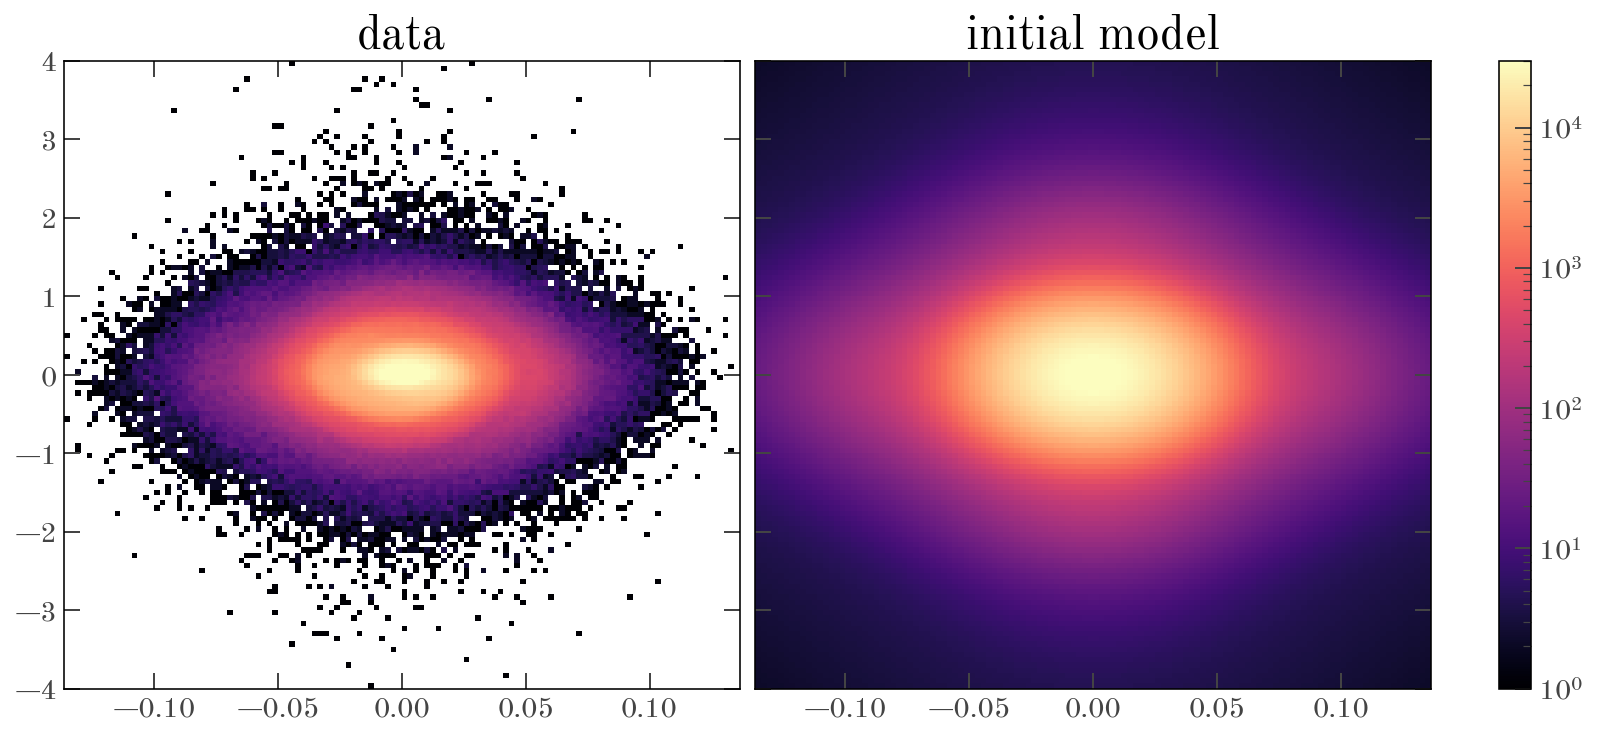

In [73]:
vlim = dict(norm=mpl.colors.LogNorm(vmax=3e4)) # vmin=0, vmax=30)

fig, axes = plt.subplots(
    1, 2, figsize=(11, 5), sharex=True, sharey=True, 
    constrained_layout=True
)

cs = axes[0].pcolormesh(data_H['vz'], data_H['z'], data_H['H'], **vlim)

cs = axes[1].pcolormesh(
    data_H['vz'], data_H['z'], 
    np.exp(model.ln_density(params0, z=data_H['z'], vz=data_H['vz']).T), 
    **vlim
)
fig.colorbar(cs, ax=axes[:2])

axes[0].set_title('data')
axes[1].set_title('initial model');

In [74]:
res = model.optimize(params0, bounds=(bounds_l, bounds_r), **data_H)
res.state

ScipyMinimizeInfo(fun_val=Array(5.03591833, dtype=float64, weak_type=True), success=True, status=0, iter_num=4792)

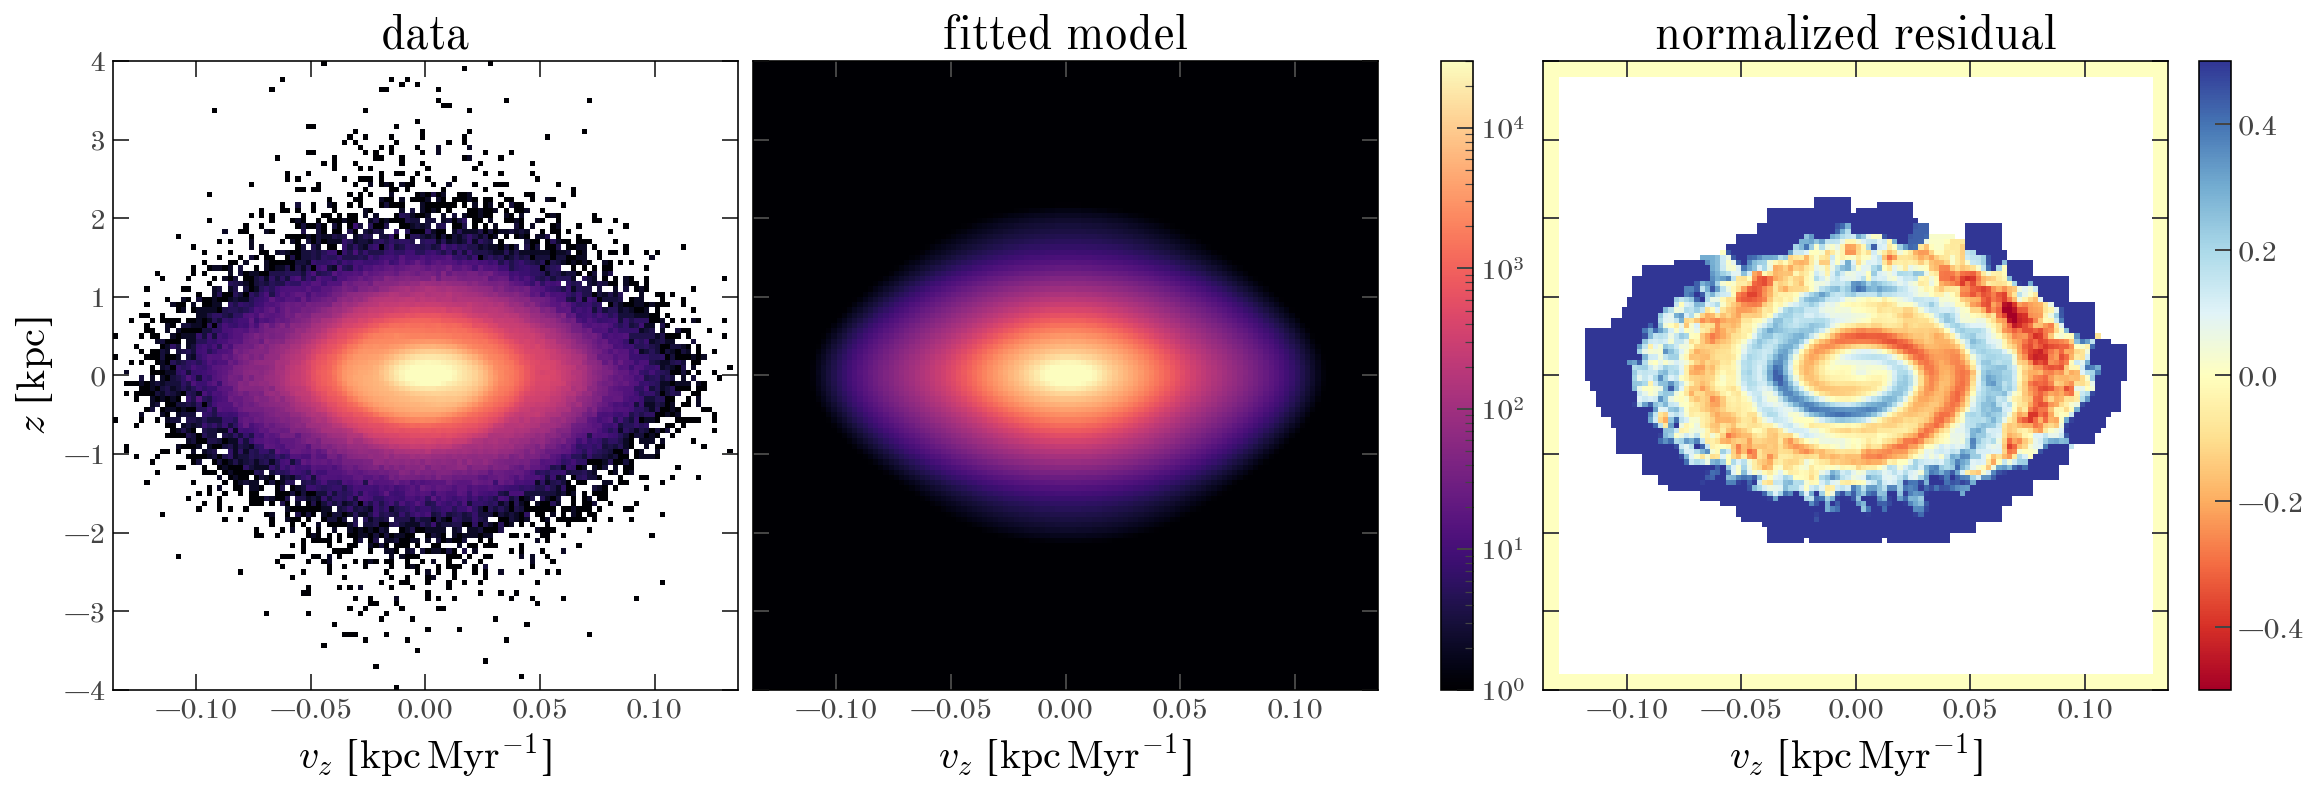

In [76]:
vlim = dict(norm=mpl.colors.LogNorm(vmax=3e4))

fig, axes = plt.subplots(
    1, 3, figsize=(16, 5.4), sharex=True, sharey=True, 
    constrained_layout=True
)

cs = axes[0].pcolormesh(data_H['vz'], data_H['z'], data_H['H'], **vlim)

model_H = np.exp(model.ln_density(res.params, z=data_H['z'], vz=data_H['vz']))
cs = axes[1].pcolormesh(data_H['vz'], data_H['z'], model_H, **vlim)
fig.colorbar(cs, ax=axes[:2])

resid = np.array((data_H['H'] - model_H) / model_H)
resid[data_H['H'] < 5] = np.nan
resid = convolve(resid, Gaussian2DKernel(0.65))
cs = axes[2].pcolormesh(
    data_H['vz'], data_H['z'], 
    resid, 
    vmin=-0.5, vmax=0.5,
    cmap='RdYlBu'
)
fig.colorbar(cs, ax=axes[2])

for ax in axes:
    ax.set_xlabel(f'$v_z$ [{u.kpc/u.Myr:latex_inline}]')
axes[0].set_ylabel(f'$z$ [{u.kpc:latex_inline}]')

axes[0].set_title('data')
axes[1].set_title('fitted model')
axes[2].set_title('normalized residual');

# TOTAL HACK SPACE:

In [77]:
import pathlib

In [83]:
files = sorted(list(pathlib.Path('.').glob('GaiaDR3*')), key=lambda x: int(str(x).split('-')[2].split('.')[0][2:]))

ScipyMinimizeInfo(fun_val=Array(1.52383843, dtype=float64, weak_type=True), success=True, status=0, iter_num=5205)
ScipyMinimizeInfo(fun_val=Array(5.2374828, dtype=float64, weak_type=True), success=True, status=0, iter_num=4017)
ScipyMinimizeInfo(fun_val=Array(2.24976066, dtype=float64, weak_type=True), success=True, status=0, iter_num=7894)
ScipyMinimizeInfo(fun_val=Array(5.03591833, dtype=float64, weak_type=True), success=True, status=0, iter_num=4792)
ScipyMinimizeInfo(fun_val=Array(3.41901401, dtype=float64, weak_type=True), success=True, status=0, iter_num=3903)
ScipyMinimizeInfo(fun_val=Array(2.06184678, dtype=float64, weak_type=True), success=True, status=0, iter_num=3617)
ScipyMinimizeInfo(fun_val=Array(1.09179705, dtype=float64, weak_type=True), success=True, status=0, iter_num=1541)
ScipyMinimizeInfo(fun_val=Array(0.44521789, dtype=float64, weak_type=True), success=True, status=0, iter_num=700)


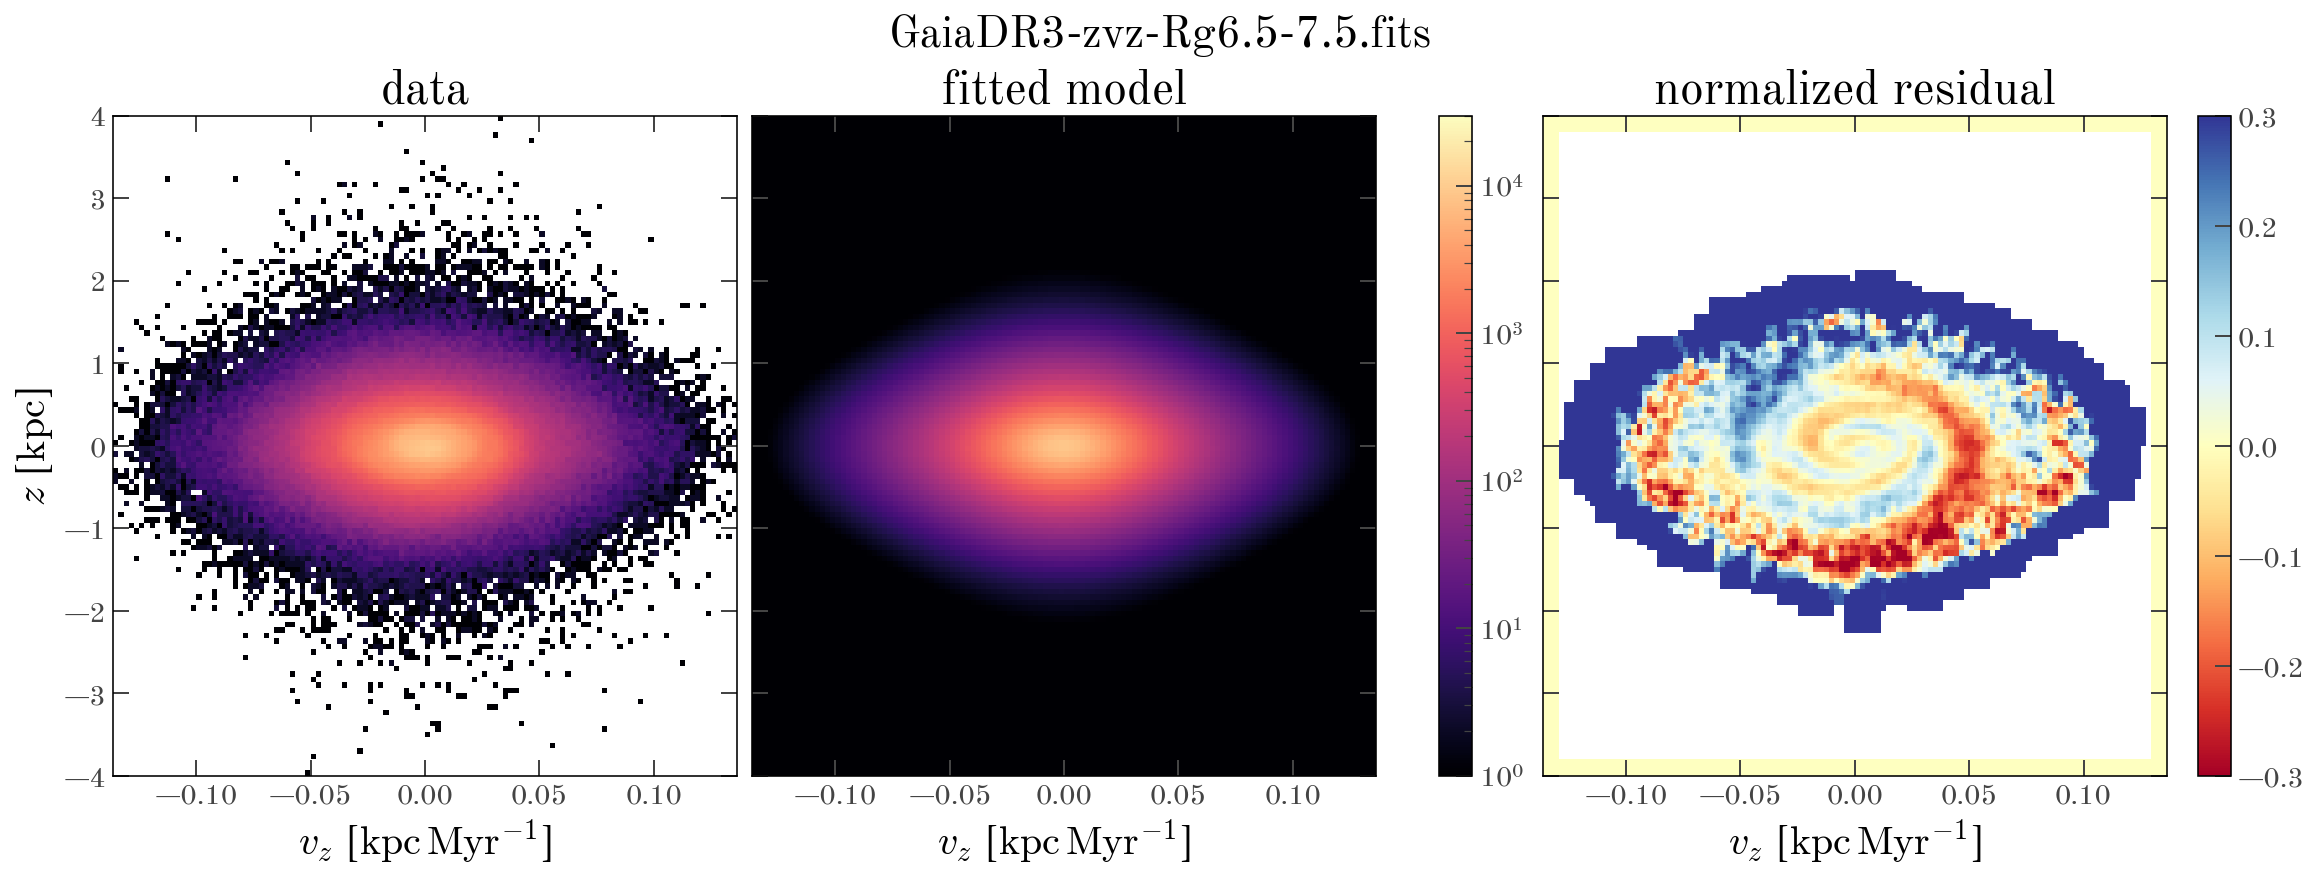

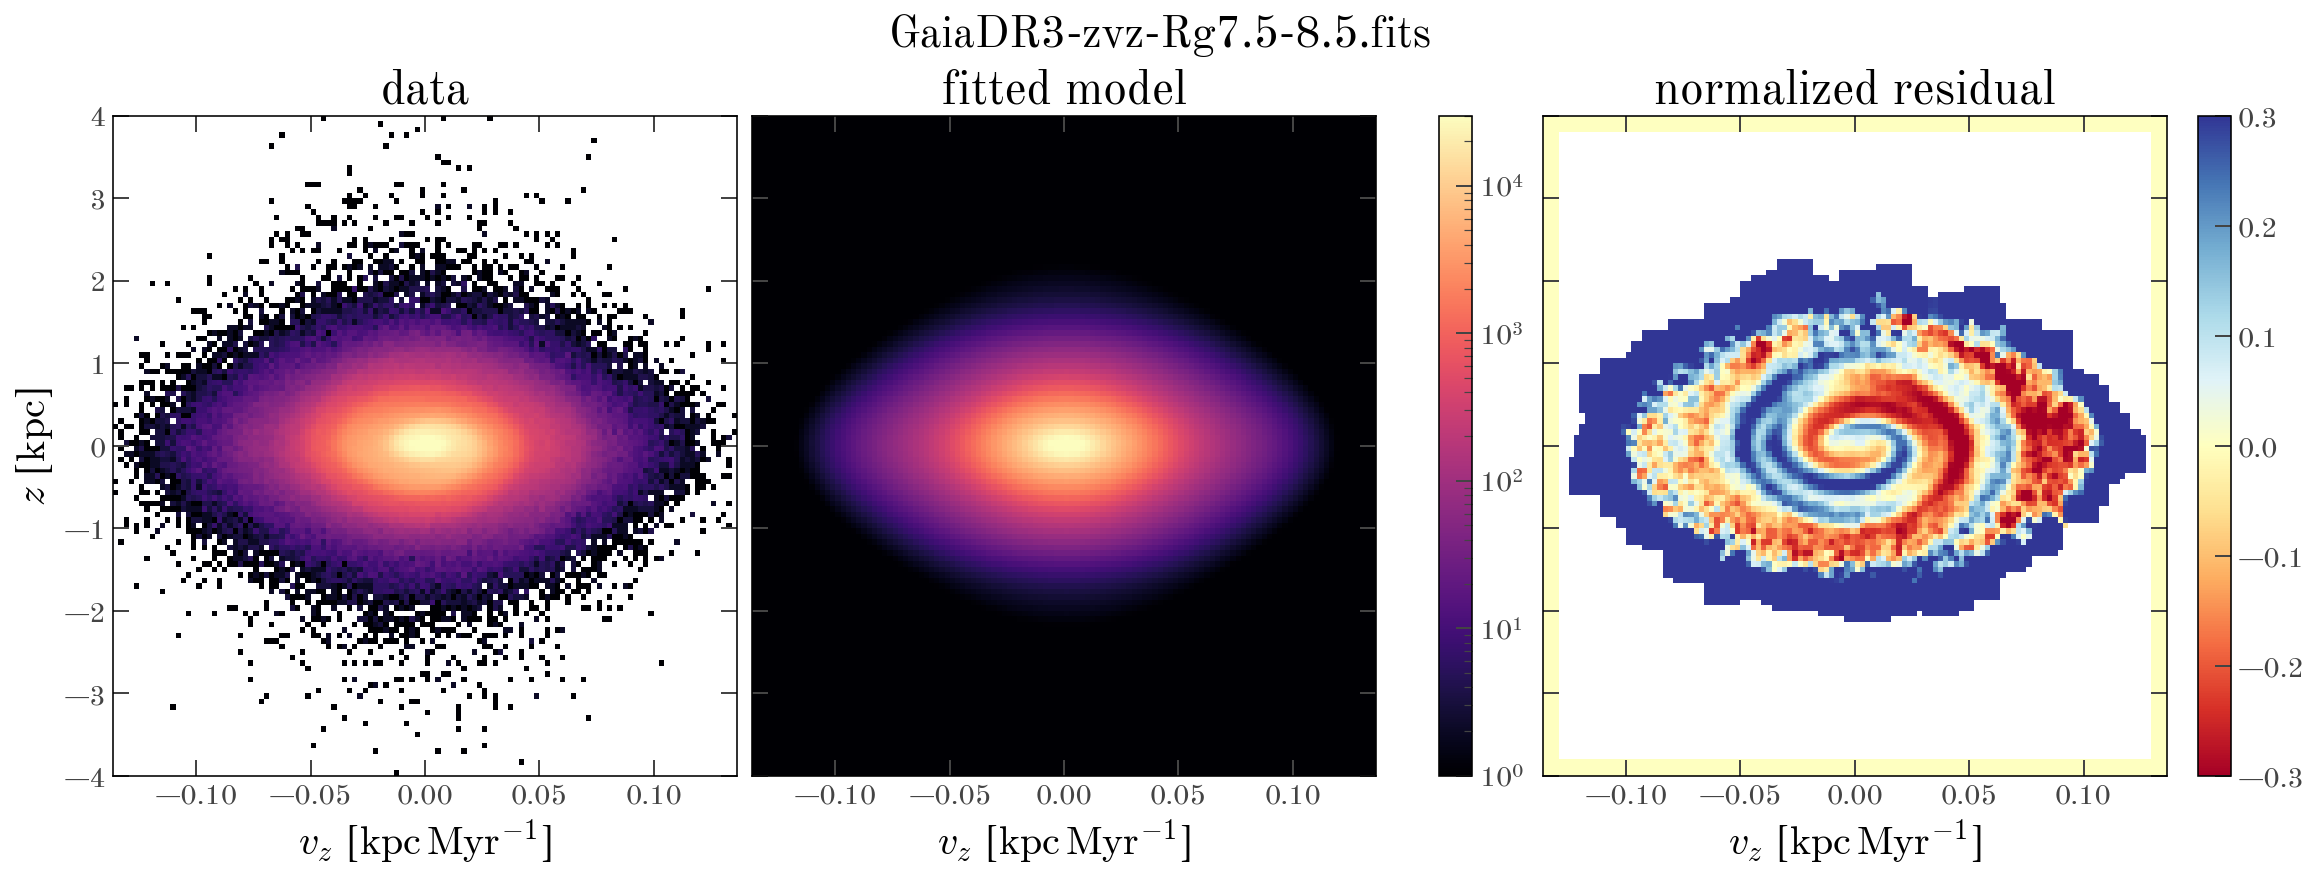

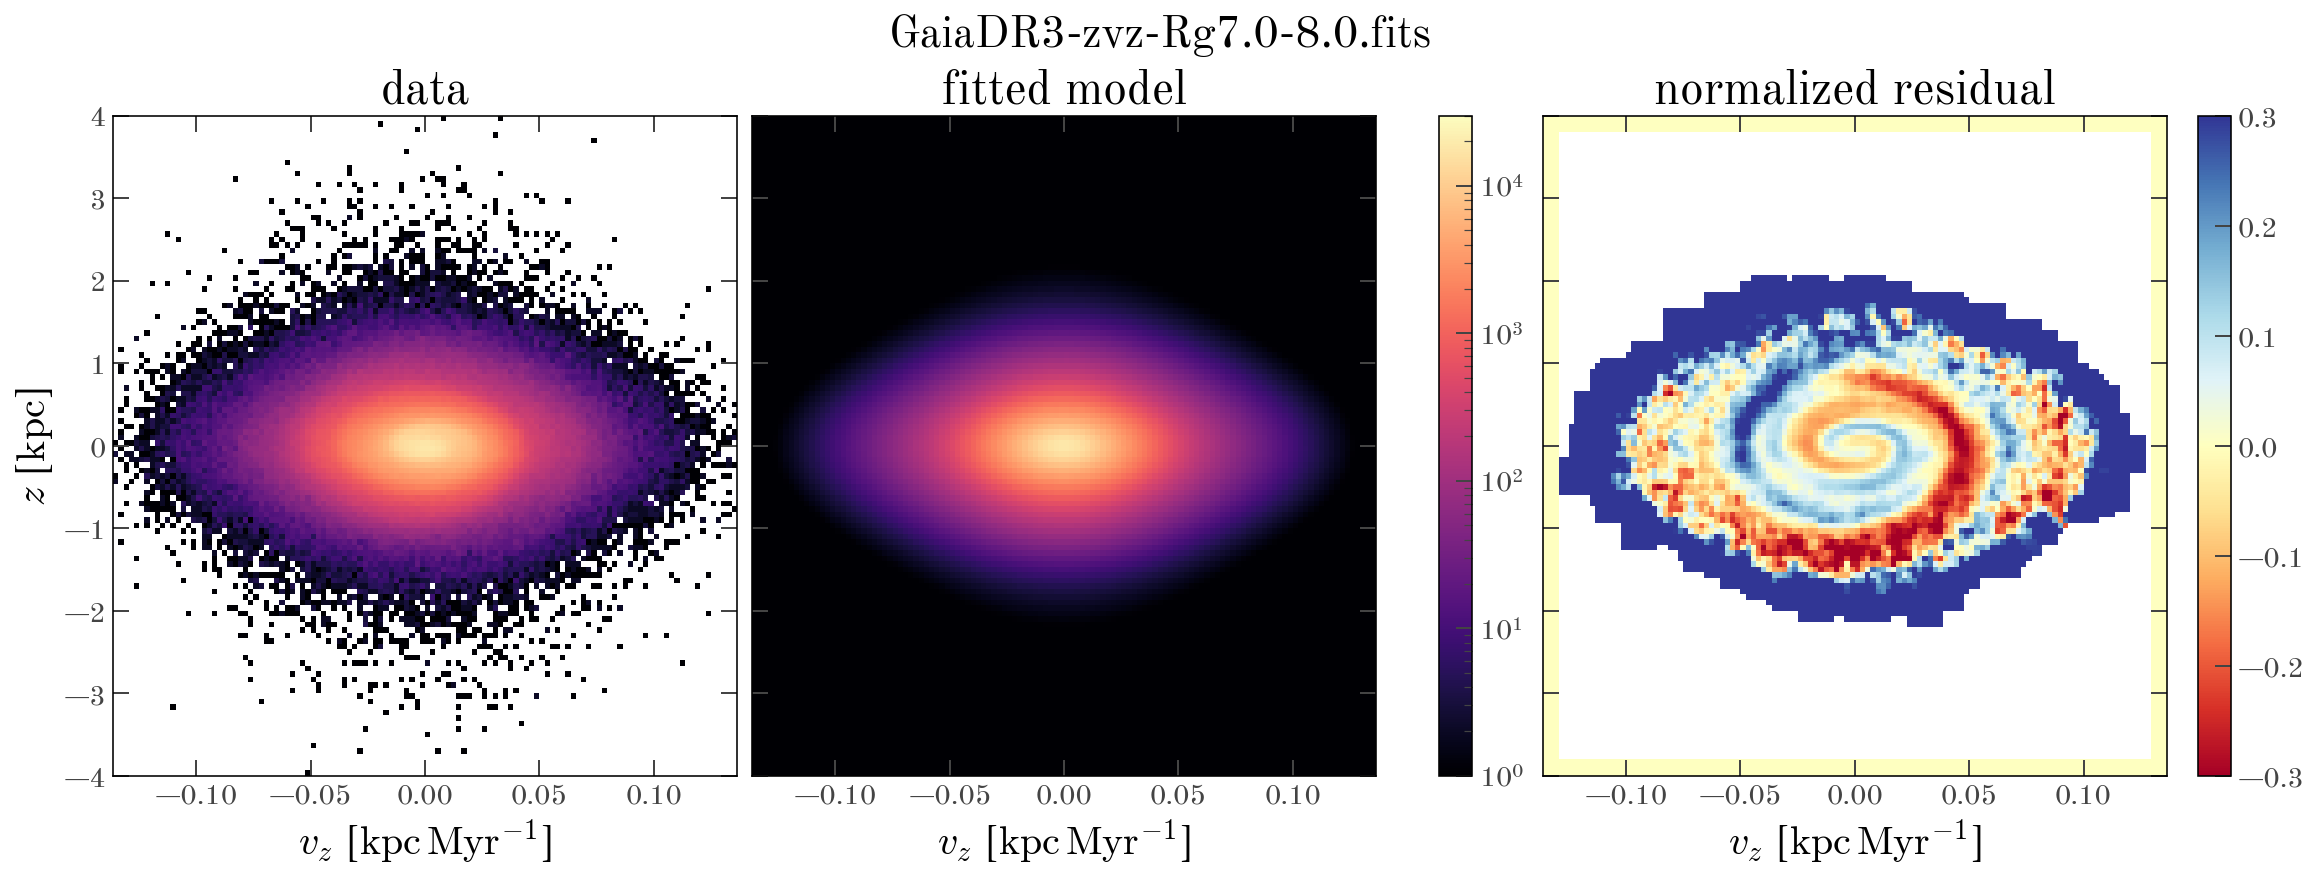

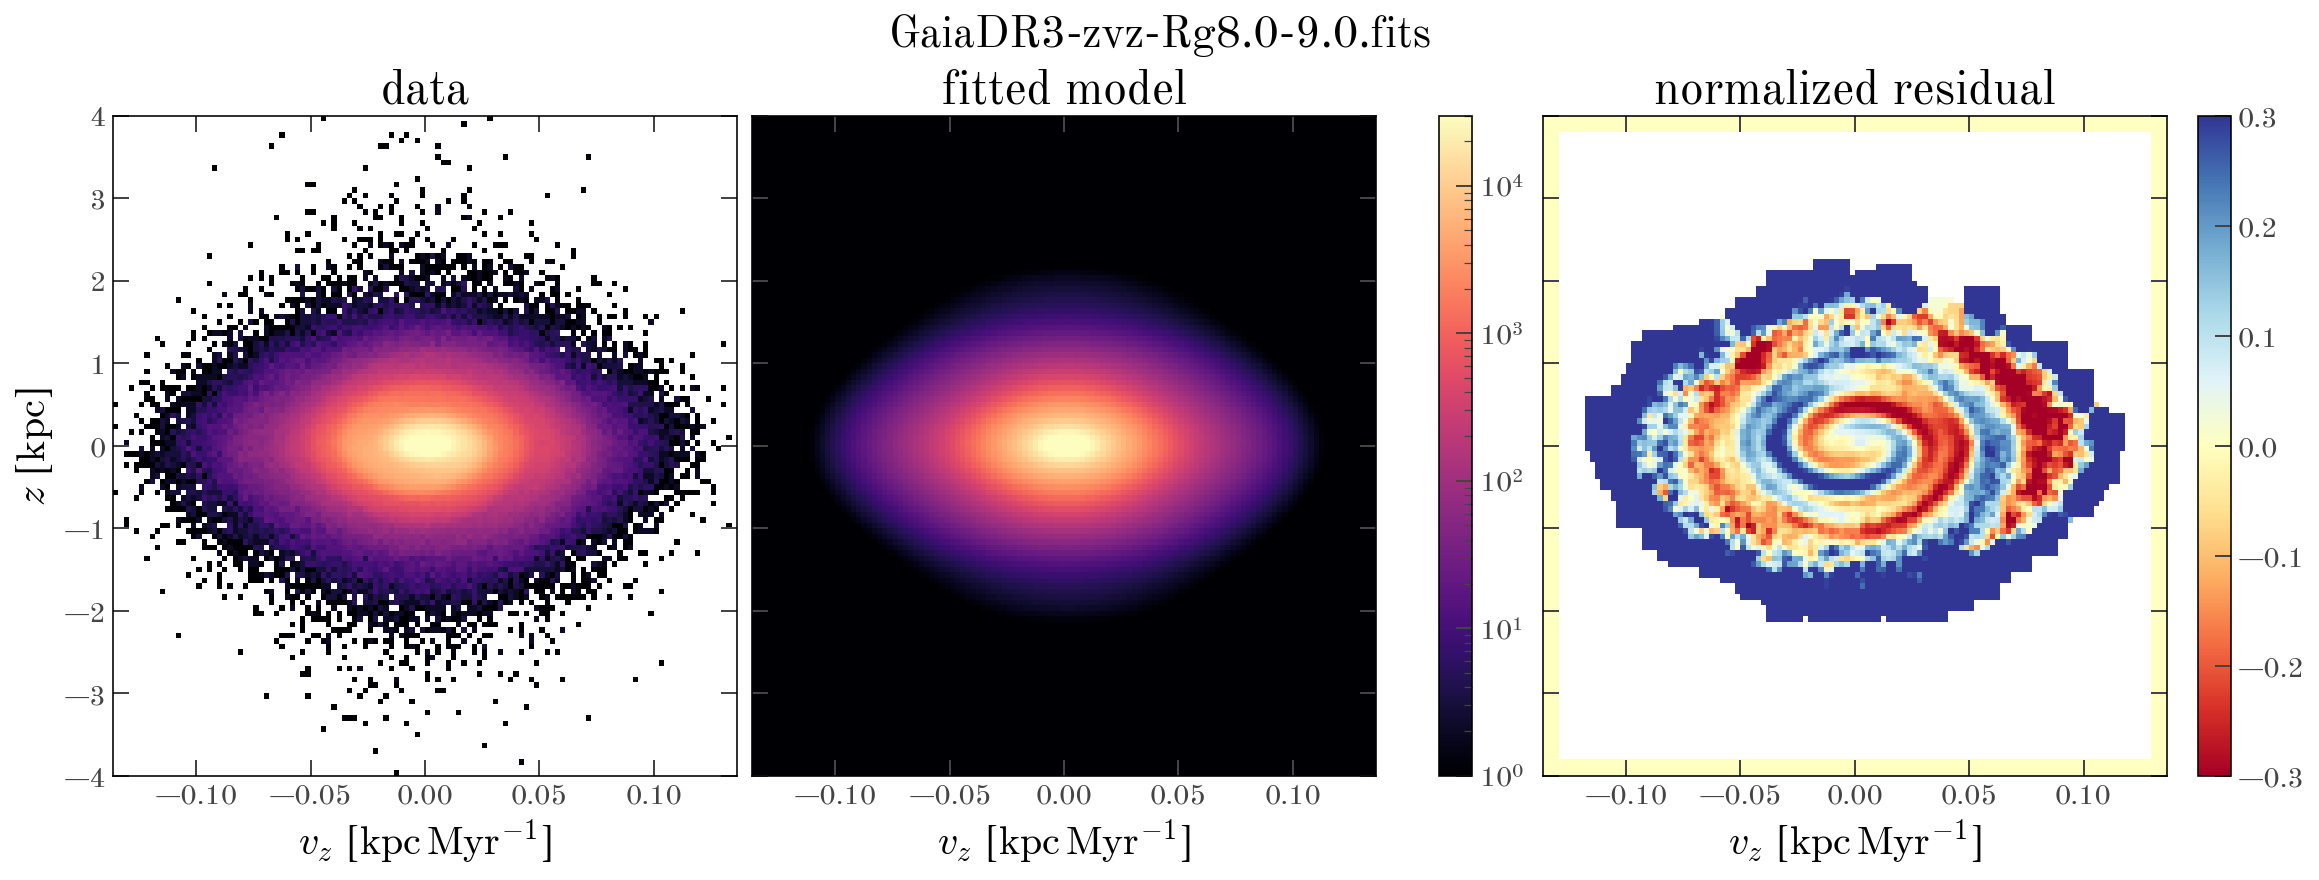

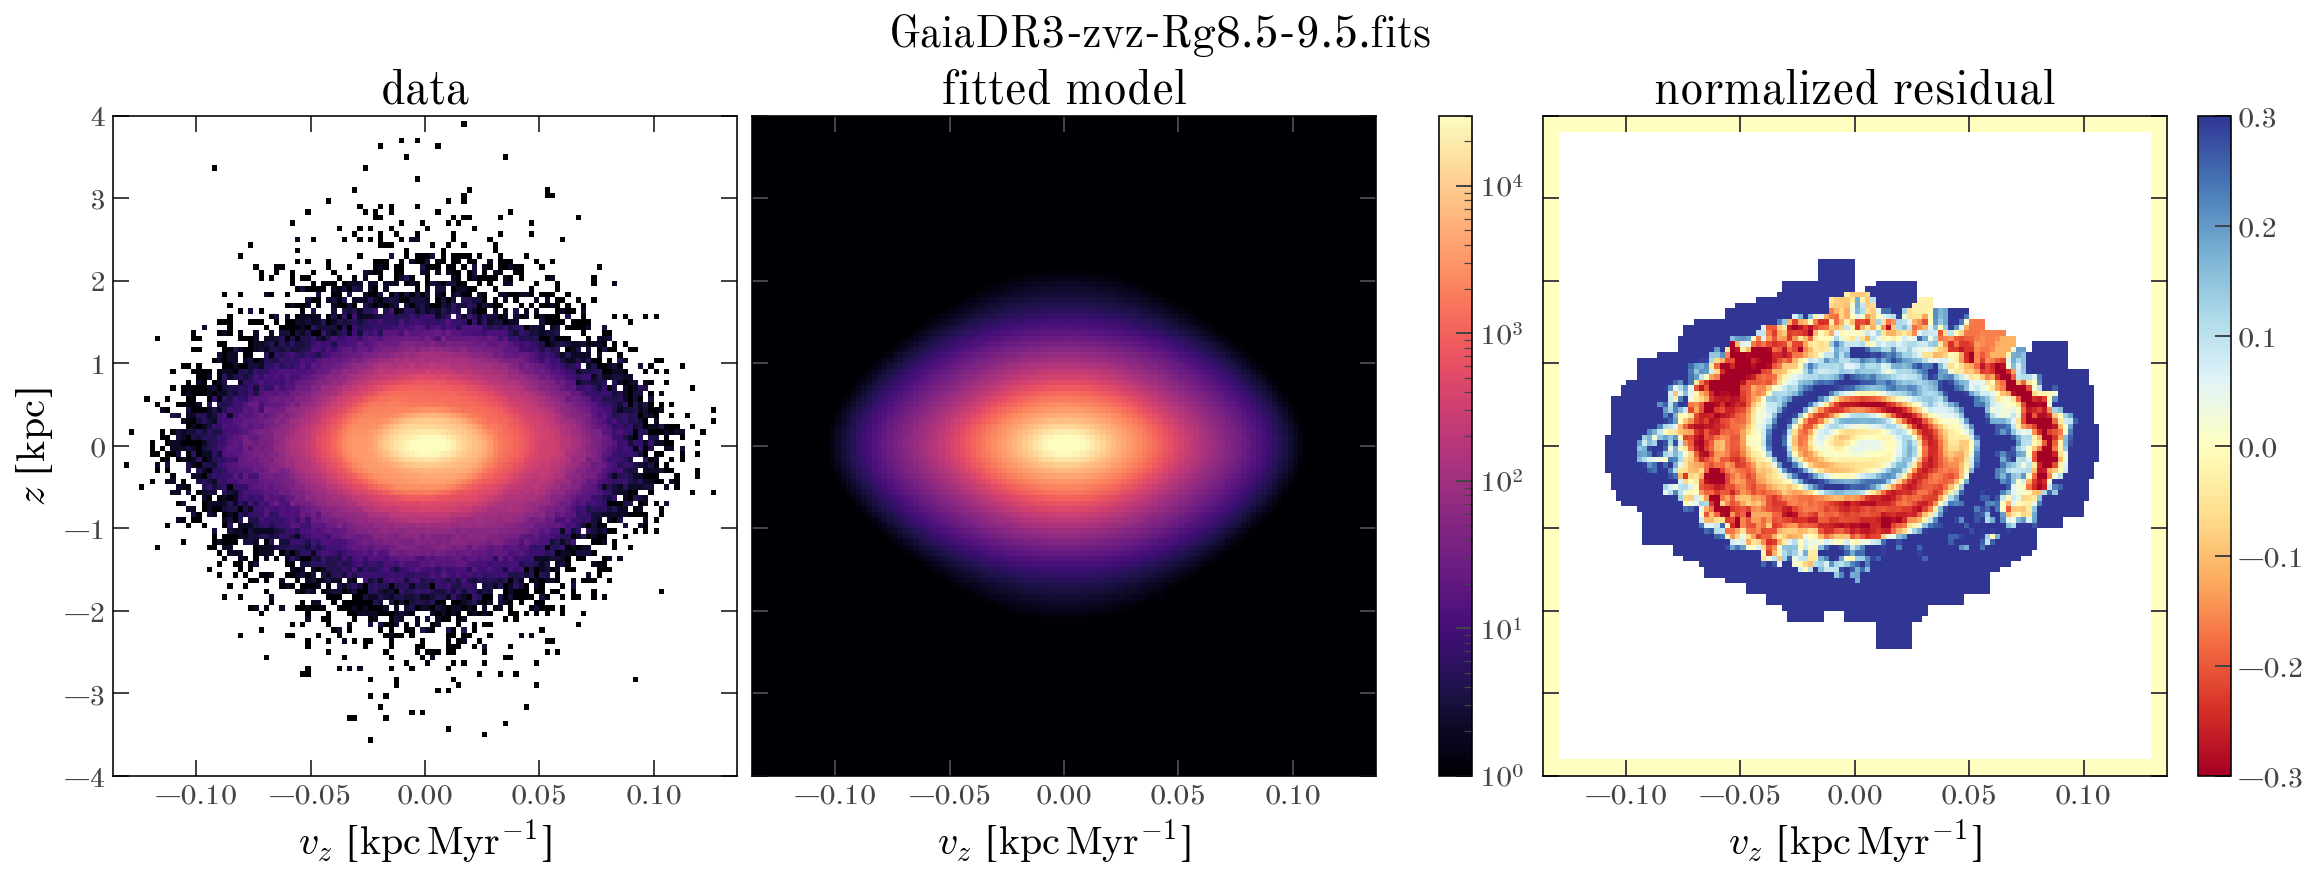

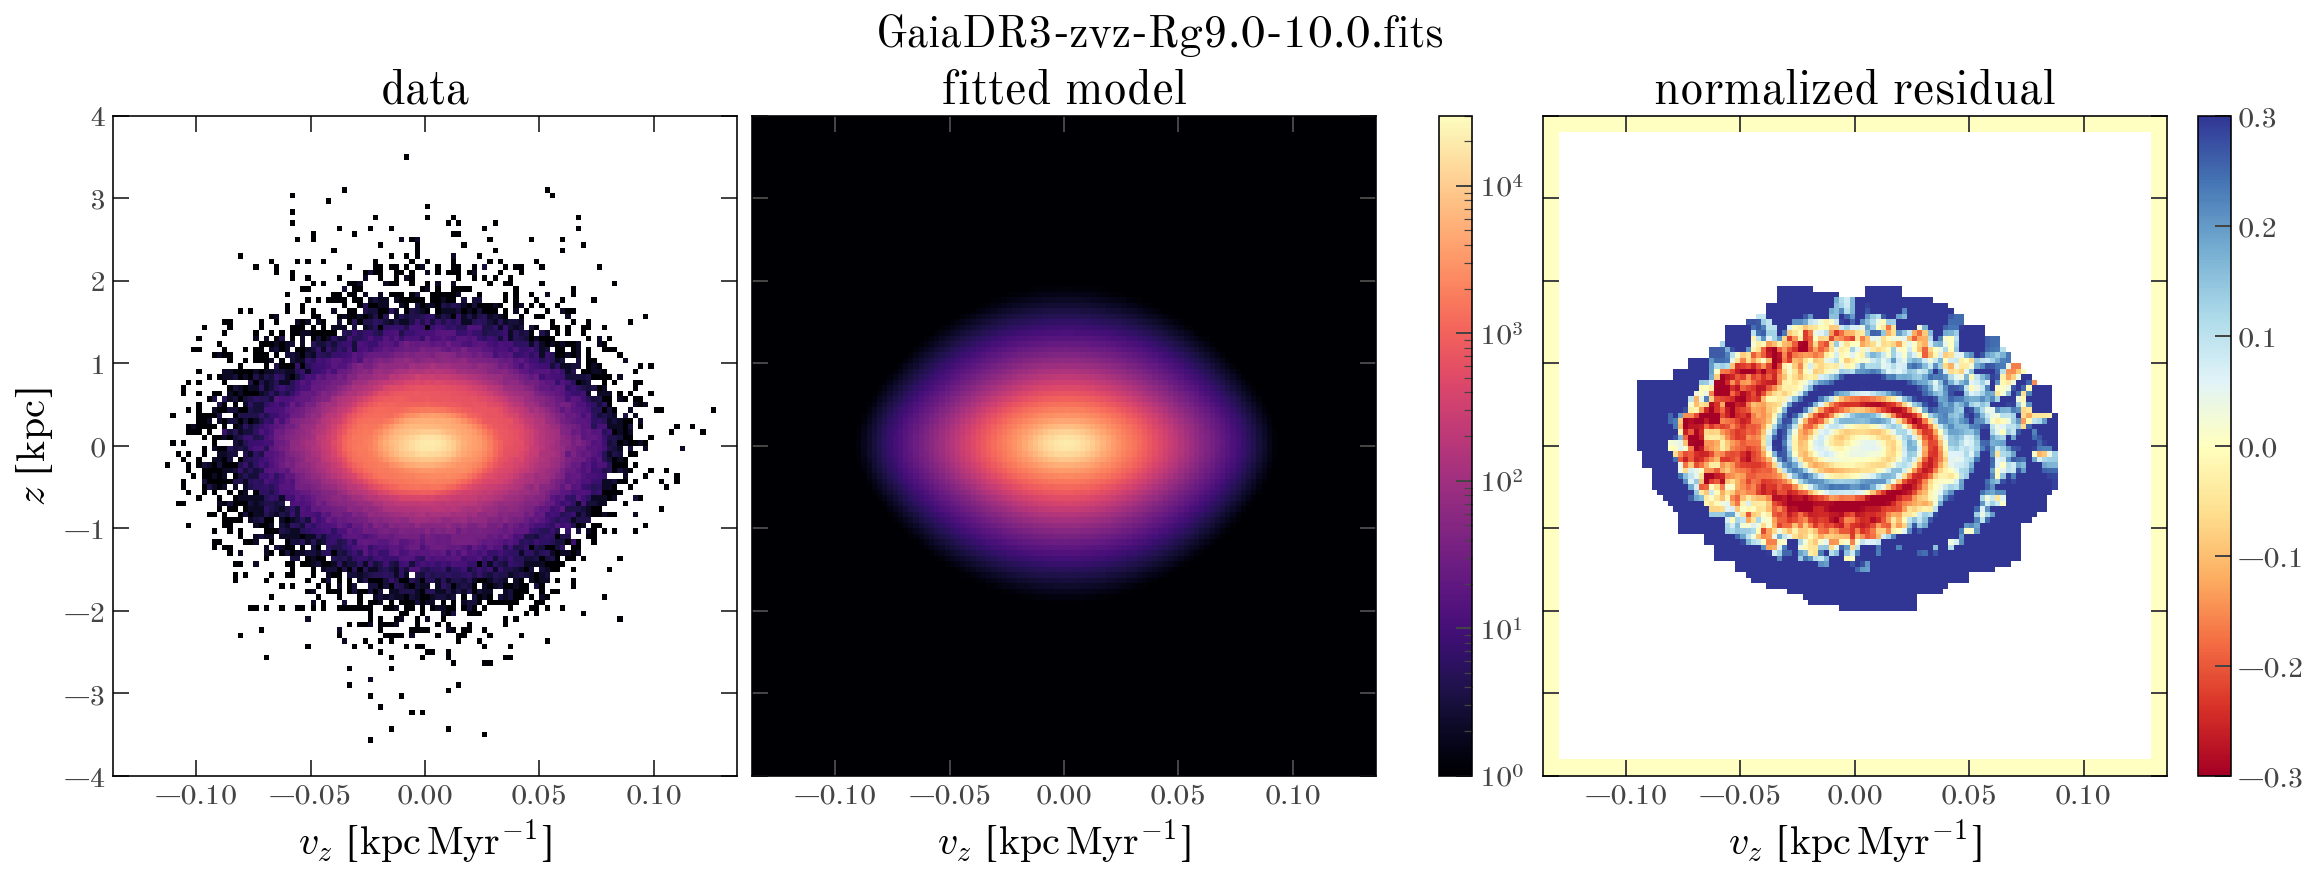

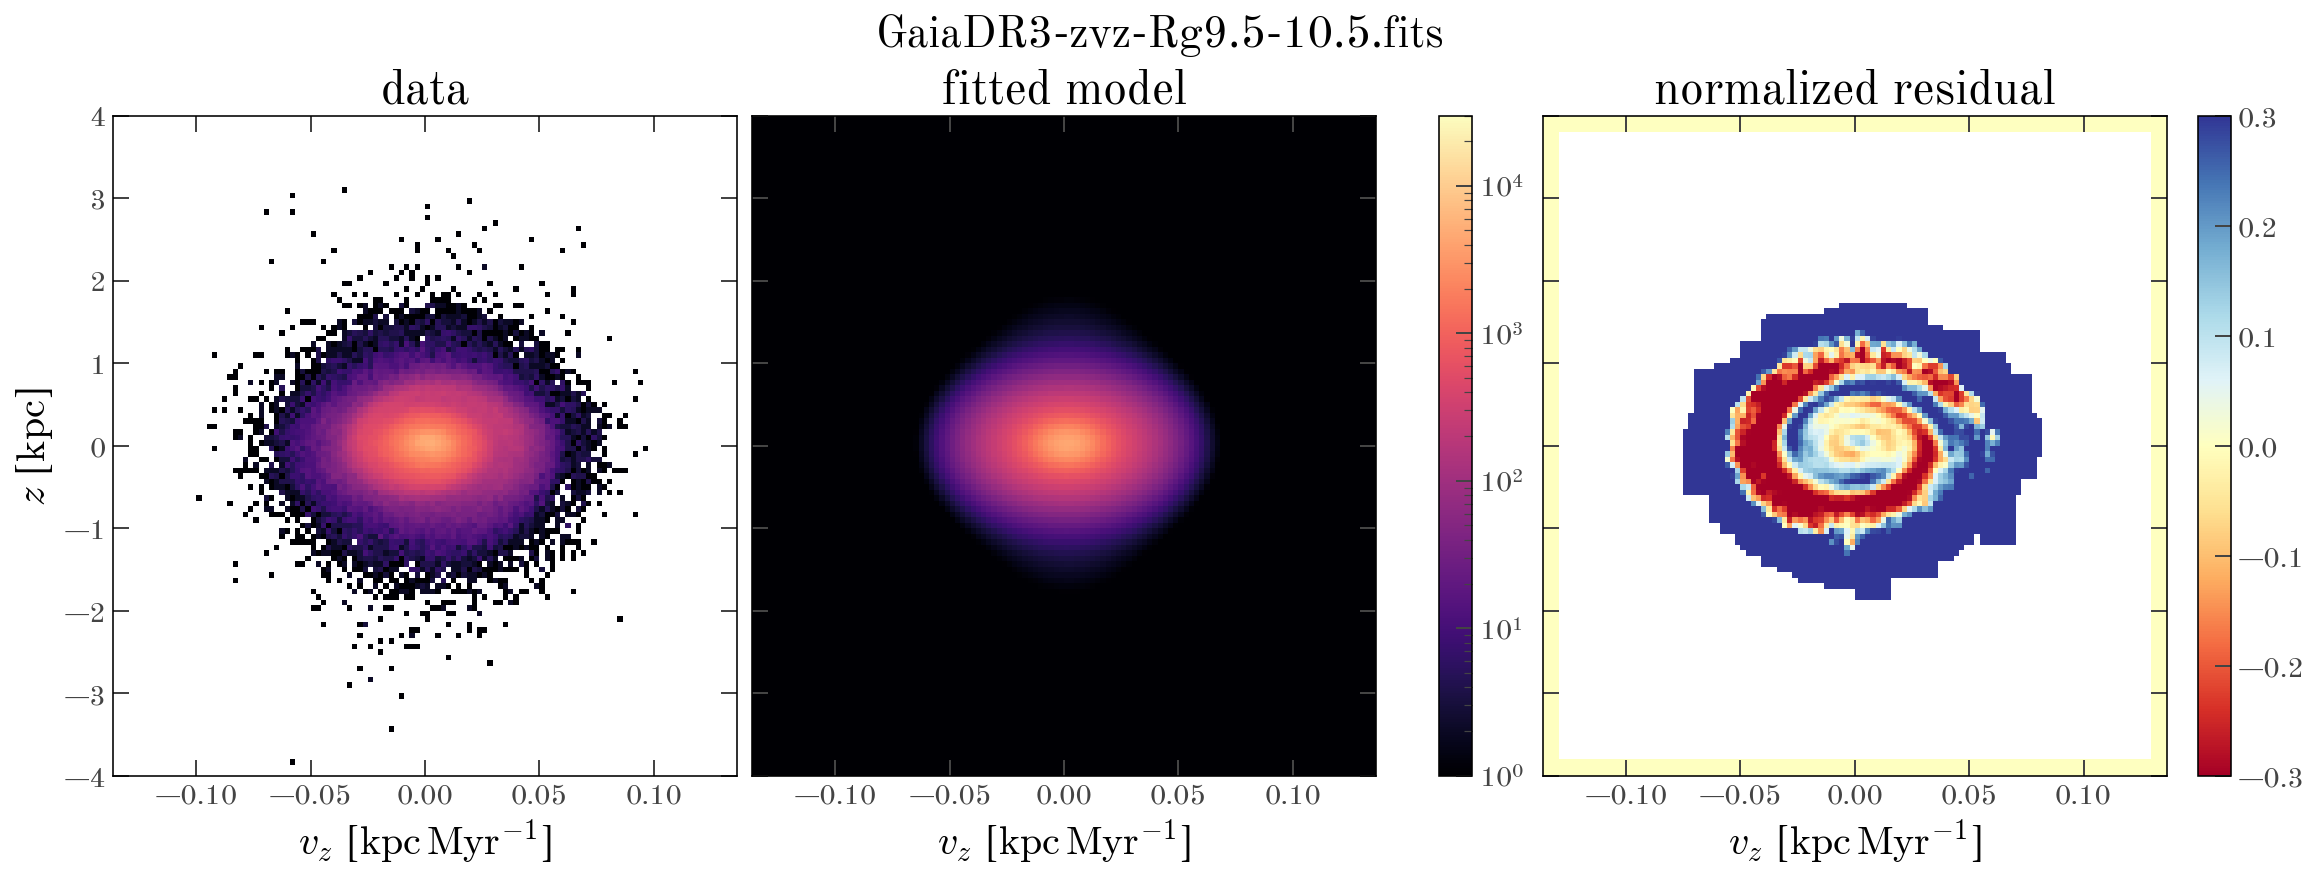

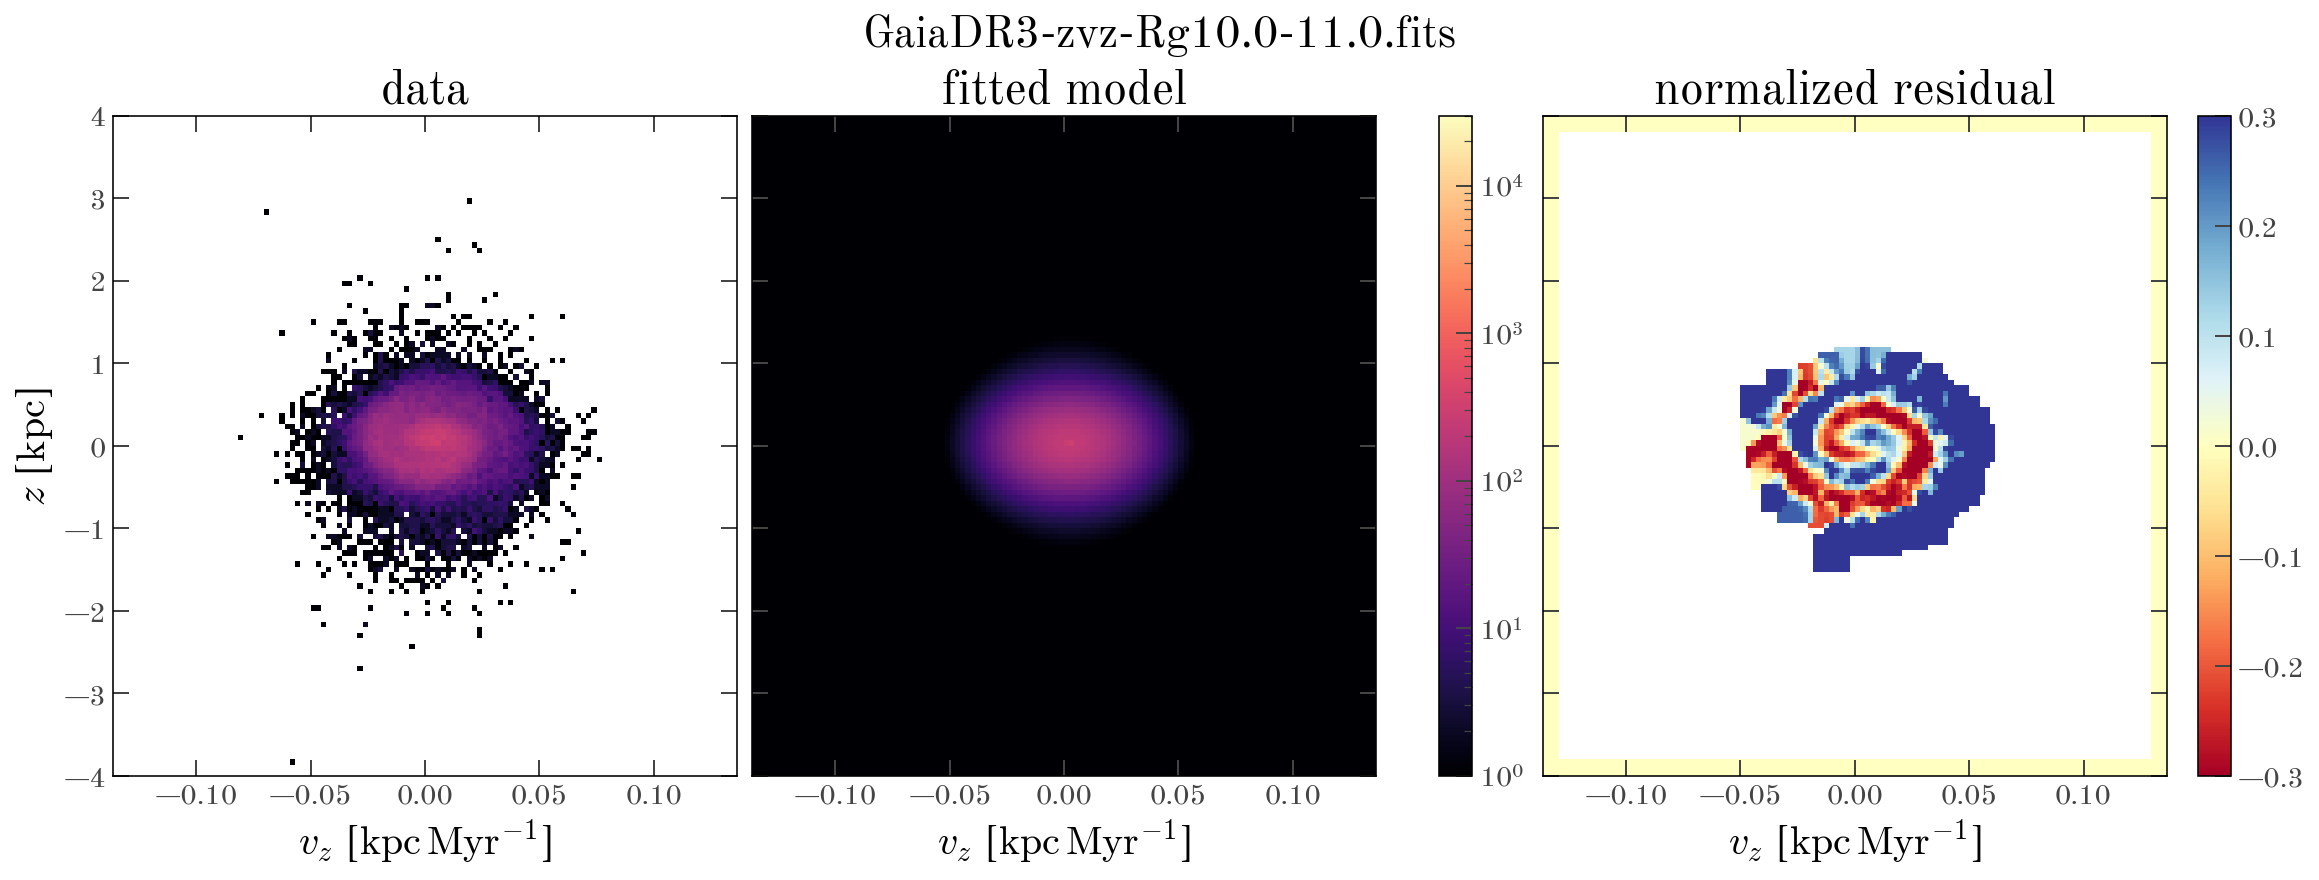

In [86]:
for file in files:
    test_data = at.QTable.read(file)
    data_H = get_data_im(test_data['z'], test_data['vz'], im_bins)
    
    res = model.optimize(params0, bounds=(bounds_l, bounds_r), **data_H)
    print(res.state)
    
    vlim = dict(norm=mpl.colors.LogNorm(vmax=3e4))

    # ---
    
    fig, axes = plt.subplots(
        1, 3, figsize=(16, 6), sharex=True, sharey=True, 
        constrained_layout=True
    )

    cs = axes[0].pcolormesh(data_H['vz'], data_H['z'], data_H['H'], **vlim)

    model_H = np.exp(model.ln_density(res.params, z=data_H['z'], vz=data_H['vz']))
    cs = axes[1].pcolormesh(data_H['vz'], data_H['z'], model_H, **vlim)
    fig.colorbar(cs, ax=axes[:2])

    resid = np.array((data_H['H'] - model_H) / model_H)
    resid[data_H['H'] < 5] = np.nan
    resid = convolve(resid, Gaussian2DKernel(0.65))
    cs = axes[2].pcolormesh(
        data_H['vz'], data_H['z'], 
        resid, 
        vmin=-0.3, vmax=0.3,
        cmap='RdYlBu'
    )
    fig.colorbar(cs, ax=axes[2])

    for ax in axes:
        ax.set_xlabel(f'$v_z$ [{u.kpc/u.Myr:latex_inline}]')
    axes[0].set_ylabel(f'$z$ [{u.kpc:latex_inline}]')

    axes[0].set_title('data')
    axes[1].set_title('fitted model')
    axes[2].set_title('normalized residual');
    
    fig.suptitle(str(file), fontsize=22)

---

In [12]:
@partial(jax.jit, static_argnames=['K'])
def ln_gmm(x, amps, scales, K):
    ln_vals = []
    for k in range(K):
        ln_dens = jax.scipy.stats.norm.logpdf(x, loc=0., scale=scales[k])
        ln_vals.append(jnp.log(amps[k]) + ln_dens)
    return jax.scipy.special.logsumexp(jnp.array(ln_vals), axis=0)

In [13]:
e4_knots = jnp.linspace(0, 1.5, 9)

@jax.jit
def distort4(eps, r, th):
    return 1 - eps * r * jnp.cos(4 * th)


@jax.jit
def distort2(eps, r, th):
    return 1 - eps * r * jnp.cos(2 * th)


@jax.jit
def distort(e2, e4, r, th):
    return 1 - e2 * r * jnp.cos(2 * th) - e4 * r * jnp.cos(4 * th)


@jax.jit
def get_distorted_rz(init_rz, th, e2_vals, ln_e4_vals):
    e2_interp = InterpolatedUnivariateSpline(
        e4_knots,
        e2_vals,
        k=3
    )
    ln_e4_interp = InterpolatedUnivariateSpline(
        e4_knots,
        ln_e4_vals,
        k=3
    )
    rz = init_rz * distort(
        e2=e2_interp(init_rz), 
        e4=jnp.exp(ln_e4_interp(init_rz)), 
        r=init_rz, 
        th=th
    )
    return rz

@jax.jit
def get_rz_th(z, vz, Omega, e2_vals, ln_e4_vals):
    x = vz / jnp.sqrt(Omega)
    y = z * jnp.sqrt(Omega)
    
    init_rz = jnp.sqrt(x**2 + y**2)
    th = jnp.arctan2(y, x)
    rz = get_distorted_rz(init_rz, th, e2_vals, ln_e4_vals)
    
    return rz, init_rz, th


@jax.jit
def ln_density(params, z, vz):
    rz, _, th = get_rz_th(
        z - params['z0'], vz - params['vz0'], 
        Omega=jnp.exp(params['ln_Omega']), 
        e2_vals=params['e2_vals'], 
        ln_e4_vals=params['ln_e4_vals']
    )
    
    amps = jnp.exp(params['ln_amps'])
    scales = jnp.exp(params['ln_scales'])
    return ln_gmm(rz, amps=amps, scales=scales, K=len(amps))


@jax.jit
def ln_poisson_likelihood(params, z, vz, H):
    # Expected number:
    ln_Lambda = ln_density(params, z, vz)
    
    # gammaln(x+1) = log(factorial(x))
    return (H * ln_Lambda - jnp.exp(ln_Lambda) - jax.scipy.special.gammaln(H + 1)).sum()


@jax.jit
def objective(params, z, vz, H):
    # ln_prior = -0.5 * jnp.array(params['amps'])**2 / 1**2 - 0.5 * jnp.log(2*np.pi*1**2)
    return -(ln_poisson_likelihood(params, z, vz, H)) / H.size

In [14]:
objective(params0, **data_H)

Array(470.43079201, dtype=float64)

In [15]:
model.objective(params0, **data_H)

Array(470.43079201, dtype=float64)

In [16]:
Omegaz0 = ((15*u.km/u.s) / (450*u.pc)).to_value(1/u.Myr)

In [17]:
# im_bins = {'z': np.linspace(-4, 4, 91)}
# im_bins['vz'] = im_bins['z'] * Omegaz0

TODO: try loading some real data and try

In [18]:
# test_data = at.QTable()
# with open("a2kpc701.p", "rb") as f:
# # with open("a2kpc630.p", "rb") as f:
# # with open("2kpc11.p", "rb") as f:
#     test_data_tmp = pickle.load(f)
# *_,test_data['z'],_,_,test_data['vz'],_ = test_data_tmp
# test_data['z'].unit = u.kpc
# test_data['vz'].unit = u.km/u.s

# test_data = at.QTable.read("GaiaDR3-zvz-Rg8.0-9.0.fits")

In [24]:
# def get_data_im(z, vz, im_bins):
#     data_H, xe, ye = np.histogram2d(
#         vz.to_value(u.kpc/u.Myr), 
#         z.to_value(u.kpc), 
#         bins=(im_bins['vz'], im_bins['z'])
#     )
#     xc = 0.5 * (xe[:-1] + xe[1:])
#     yc = 0.5 * (ye[:-1] + ye[1:])
#     xc, yc = np.meshgrid(xc, yc)
    
#     return xc, yc, data_H

# # xc, yc, data_H = get_data_im(test_data['z'], test_data['vz'], im_bins)
# xc, yc, HH = get_data_im(test_data['z'], test_data['vz'], im_bins)
# data_H = {'z': yc, 'vz': xc, 'H': HH.T}

In [42]:
# params0 = {
#     'vz0': 0.,
#     'z0': 0.,
#     'ln_amps': np.array([9, 6., 2, 2., 1.]),
#     'ln_scales': np.log([0.1, 0.2, 0.5, 1., 2.5]),
#     'ln_Omega': np.log(Omegaz0/1.5),
#     'e2_vals': -np.array([1e-2]*9),
#     'ln_e4_vals': np.array([-6.] * 2 + [-2] * 7)
# }

# bounds_l = {
#     'vz0': -0.1,
#     'z0': -0.5,
#     'ln_amps': np.full_like(params0['ln_amps'], -5),
#     'ln_scales': np.full_like(params0['ln_scales'], -8),
#     'ln_Omega': -5,
#     'e2_vals': np.full_like(params0['e2_vals'], -1),
#     'ln_e4_vals': np.full_like(params0['ln_e4_vals'], -8)
# }

# bounds_r = {
#     'vz0': 0.1,
#     'z0': 0.5,
#     'ln_amps': np.full_like(params0['ln_amps'], 12),
#     'ln_scales': np.full_like(params0['ln_scales'], 3),
#     'ln_Omega': 0,
#     'e2_vals': np.full_like(params0['e2_vals'], 1),
#     'ln_e4_vals': np.full_like(params0['ln_e4_vals'], 0)
# }

params02 = {
    'vz0': 0.,
    'z0': 0.,
    'ln_amps': np.array([9, 6., 2, 2., 1.]),
    'ln_scales': np.log([0.1, 0.2, 0.5, 1., 2.5]),
    'ln_Omega': np.log(Omegaz0/1.5),
    'e2_vals': -np.array([1e-2]*9),
    'ln_e4_vals': np.array([-6.] * 2 + [-2] * 7)
}

bounds_l2 = {
    'vz0': -0.1,
    'z0': -0.5,
    'ln_amps': np.full_like(params0['ln_amps'], -5),
    'ln_scales': np.full_like(params0['ln_scales'], -8),
    'ln_Omega': -5,
    'e2_vals': np.full_like(params0['e2_vals'], -1),
    'ln_e4_vals': np.full_like(params0['ln_e4_vals'], -8)
}

bounds_r2 = {
    'vz0': 0.1,
    'z0': 0.5,
    'ln_amps': np.full_like(params0['ln_amps'], 12),
    'ln_scales': np.full_like(params0['ln_scales'], 3),
    'ln_Omega': 0,
    'e2_vals': np.full_like(params0['e2_vals'], 1),
    'ln_e4_vals': np.full_like(params0['ln_e4_vals'], 0)
}

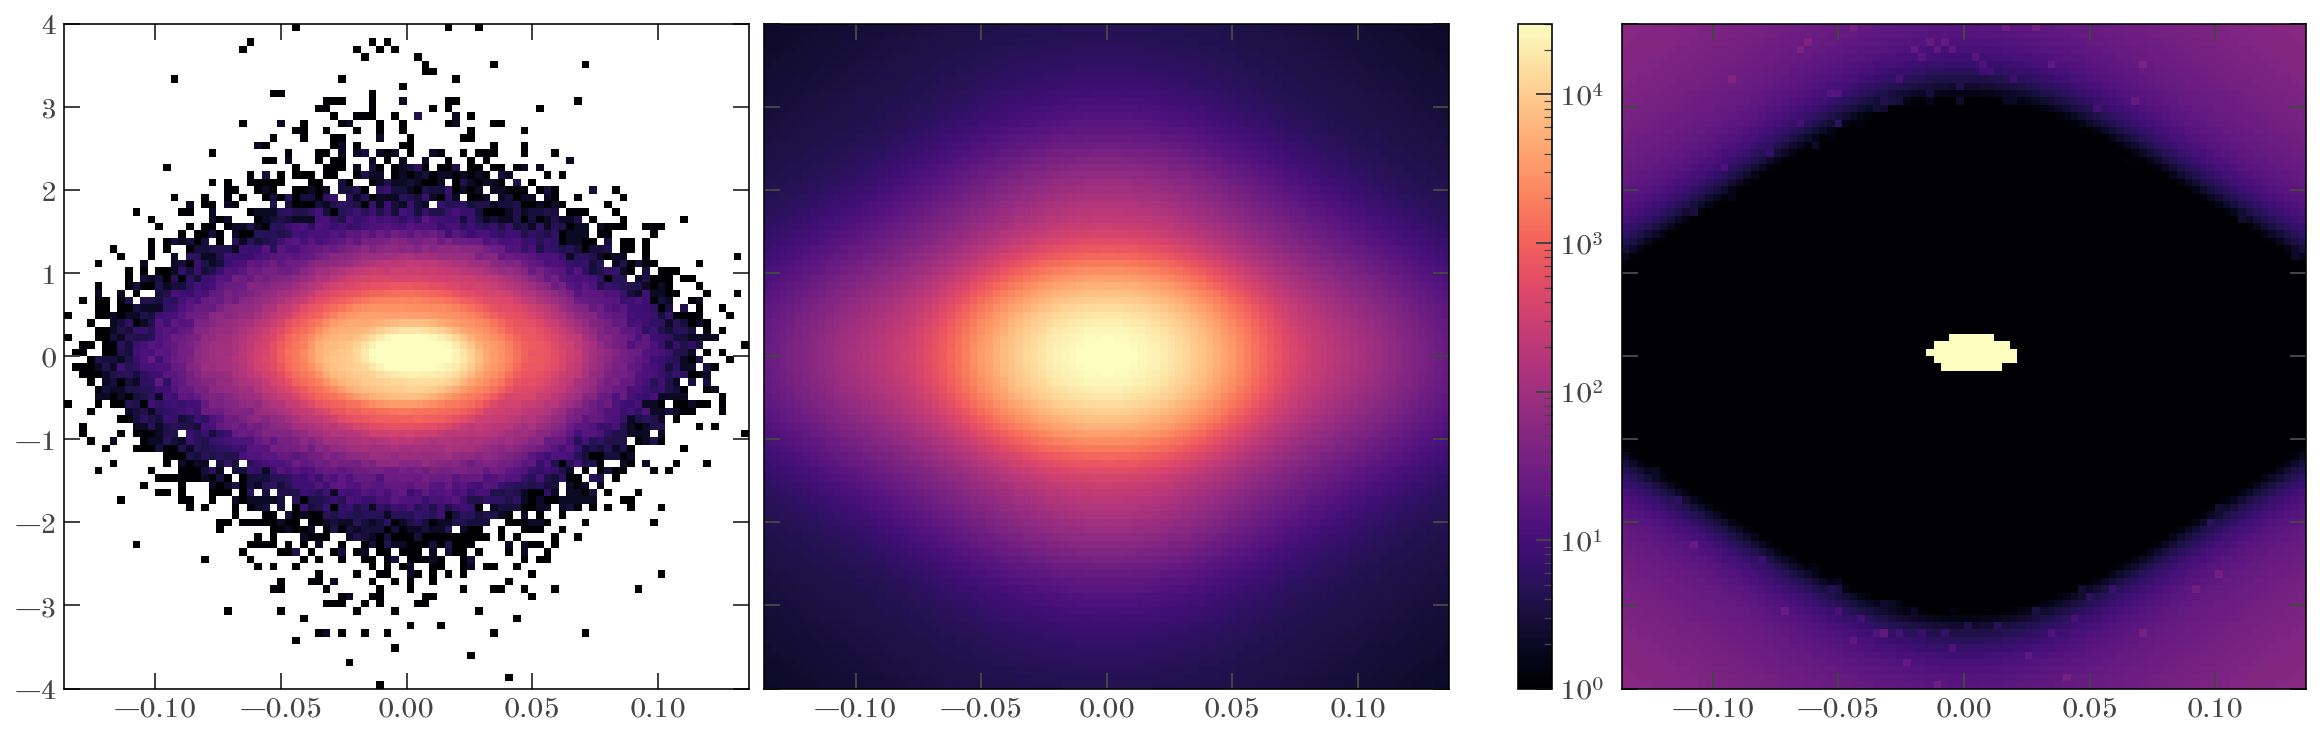

In [37]:
vlim = dict(norm=mpl.colors.LogNorm(vmax=3e4)) # vmin=0, vmax=30)

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True, 
                         constrained_layout=True)

cs = axes[0].pcolormesh(im_bins['vz'], im_bins['z'], data_H['H'], **vlim)

cs = axes[1].pcolormesh(xc, yc, np.exp(ln_density(params0, yc, xc).T), **vlim)
# cs = axes[1].pcolormesh(xc, yc, np.exp(ln_density(params0, yc, xc).T), 
#                         **vlim)
fig.colorbar(cs, ax=axes[:2])

cs = axes[2].pcolormesh(
    xc, yc, data_H['H'] - np.exp(ln_density(params0, yc, xc).T), 
    vmin=-10, vmax=10
)

In [38]:
objective(params0, **data_H) # yc, xc, data_H.T)

Array(470.43079201, dtype=float64)

In [39]:
model.objective(params0, **data_H) # yc, xc, data_H.T)

Array(470.43079201, dtype=float64)

In [40]:
# optimizer = jaxopt.ScipyMinimize(
#     fun=objective, 
#     method='L-BFGS-B', 
#     maxiter=16384,
#     options=dict(disp=True)
# )
# res = optimizer.run(init_params=params0, z=yc, vz=xc, H=data_H.T)
# res.state


optimizer = jaxopt.ScipyBoundedMinimize(
    fun=model.objective, 
    method='L-BFGS-B',
    maxiter=16384,
    options=dict(disp=False)
)
res = optimizer.run(
    init_params=params0, # z=yc, vz=xc, H=data_H.T,
    bounds=(bounds_l, bounds_r),
    **data_H
)
res.state

ScipyMinimizeInfo(fun_val=Array(7.96199474, dtype=float64, weak_type=True), success=True, status=0, iter_num=4133)

In [61]:
res.params

{'e2_vals': Array([-1.00000000e+00, -5.60619241e-01, -3.05431988e-01, -4.43062570e-01,
        -2.22211214e-01,  4.26681061e-01,  6.06314305e-01, -9.25238344e-02,
         3.41536829e-04], dtype=float64),
 'ln_Omega': Array(-2.53085646, dtype=float64),
 'ln_amps': Array([ 8.45672004,  8.32211171,  6.34754096, -2.29207441, -0.27520368],      dtype=float64),
 'ln_e4_vals': Array([-6.01338768, -2.02367133, -2.87085631, -4.78556754, -1.3159475 ,
        -2.14580406, -1.99707568, -2.00190273, -1.99976175], dtype=float64),
 'ln_scales': Array([-3.49378547, -2.70925456, -2.13198794,  1.85923182,  1.9498724 ],      dtype=float64),
 'vz0': Array(0.00119781, dtype=float64),
 'z0': Array(0.01253432, dtype=float64)}

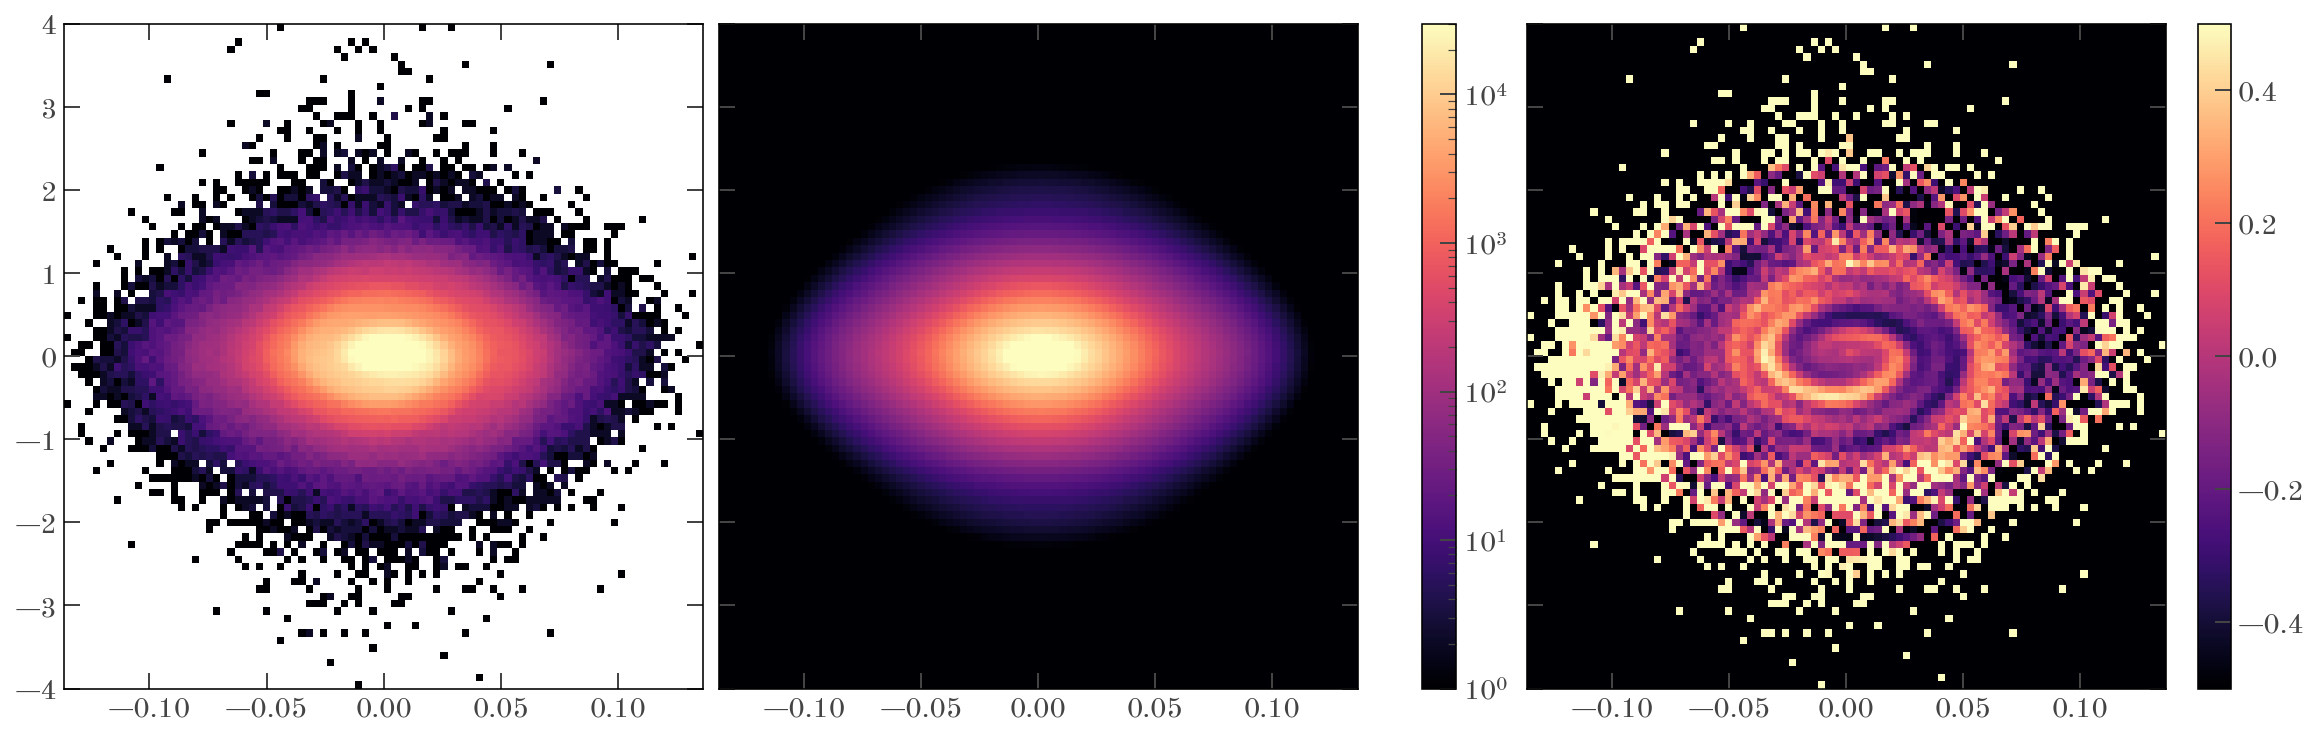

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True, 
                         constrained_layout=True)

cs = axes[0].pcolormesh(im_bins['vz'], im_bins['z'], data_H.T, **vlim)

model_H = np.exp(ln_density(res.params, yc, xc))
cs = axes[1].pcolormesh(xc, yc, model_H,
                        **vlim)
fig.colorbar(cs, ax=axes[0:2])

cs = axes[2].pcolormesh(
    xc, yc, (data_H.T - model_H) / model_H, 
    vmin=-.5, vmax=.5
)
fig.colorbar(cs, ax=axes[2])

HACK:

In [408]:
from astropy.convolution import convolve, Gaussian2DKernel

vz_scale = 1.5 * MAD(test_data['vz'])
z_scale = 1.5 * MAD(test_data['z'])
data_H2, xe2, ye2 = np.histogram2d(
    (test_data['vz'] / vz_scale).decompose().value,
    (test_data['z'] / z_scale).decompose().value,
    bins=np.linspace(-8, 8, 121)
)
xc2 = 0.5 * (xe2[:-1] + xe2[1:]) * vz_scale.to_value(u.kpc/u.Myr)
yc2 = 0.5 * (ye2[:-1] + ye2[1:]) * z_scale.to_value(u.kpc)
xc2, yc2 = np.meshgrid(xc2, yc2)

optimizer2 = jaxopt.ScipyBoundedMinimize(
    fun=objective, 
    method='L-BFGS-B', 
    maxiter=16384,
    options=dict(disp=False)
)
res2 = optimizer.run(
    init_params=res.params, z=yc2, vz=xc2, H=data_H2.T,
    bounds=(bounds_l, bounds_r)
)
res2.state

ScipyMinimizeInfo(fun_val=DeviceArray(6.27306212, dtype=float64, weak_type=True), success=True, status=0, iter_num=994)

In [409]:
res2.params

{'e2_vals': DeviceArray([ 1.00000000e+00,  6.08940723e-01,  3.28517852e-01,
               4.99717318e-01,  1.64348818e-01, -4.11252438e-01,
              -6.10278604e-01,  9.33809801e-02, -4.48680050e-04],            dtype=float64),
 'ln_Omega': DeviceArray(-2.51064655, dtype=float64),
 'ln_amps': DeviceArray([ 6.8467268 ,  6.72327771,  4.83491904, -2.28765774,
              -0.24443879], dtype=float64),
 'ln_e4_vals': DeviceArray([-5.96024884, -1.97205593, -2.93563508, -4.72827375,
              -1.3311765 , -2.14174289, -1.99811917, -2.00167711,
              -1.99978996], dtype=float64),
 'ln_scales': DeviceArray([-3.51892085, -2.72663178, -2.15377232,  1.85482968,
               1.91919132], dtype=float64),
 'vz0': DeviceArray(0.00119083, dtype=float64),
 'z0': DeviceArray(0.01273615, dtype=float64)}

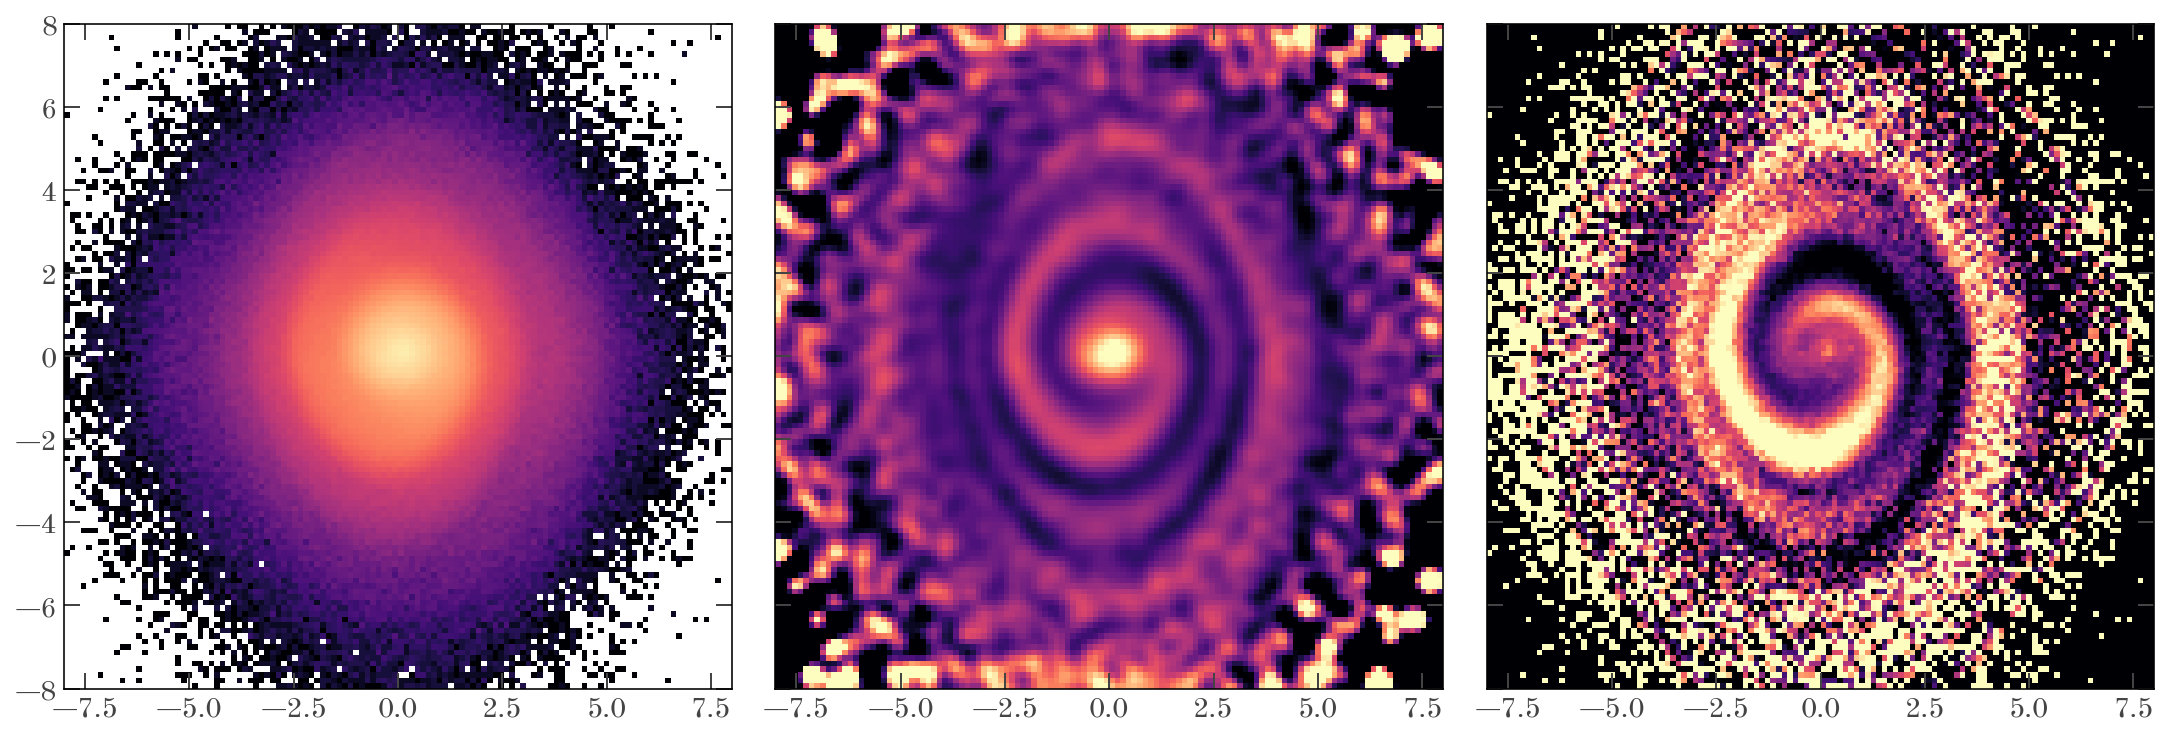

In [414]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True, 
                         constrained_layout=True)

cs = axes[0].pcolormesh(xe2, ye2, data_H2.T, **vlim)

kernel = Gaussian2DKernel(3)
H_sm = convolve(data_H2, kernel)
dH = (data_H2 - H_sm) / H_sm

kernel = Gaussian2DKernel(1.5)
dH_sm = convolve(dH, kernel)
        
cs = axes[1].pcolormesh(
    xe2, 
    ye2,
    dH_sm.T,
    vmin=-0.3, 
    vmax=0.3,
    cmap='magma'
)

model_H2 = np.exp(
    ln_density(
        res2.params, 
        yc2,
        xc2
    )
)
cs = axes[2].pcolormesh(
    xc2 / vz_scale.to_value(u.kpc/u.Myr), 
    yc2 / z_scale.to_value(u.kpc), 
    (data_H2.T - model_H2) / model_H2,
#     convolve((data_H2.T - model_H2) / model_H2, Gaussian2DKernel(1.)),
    vmin=-0.3, 
    vmax=0.3,
    cmap='magma',
)

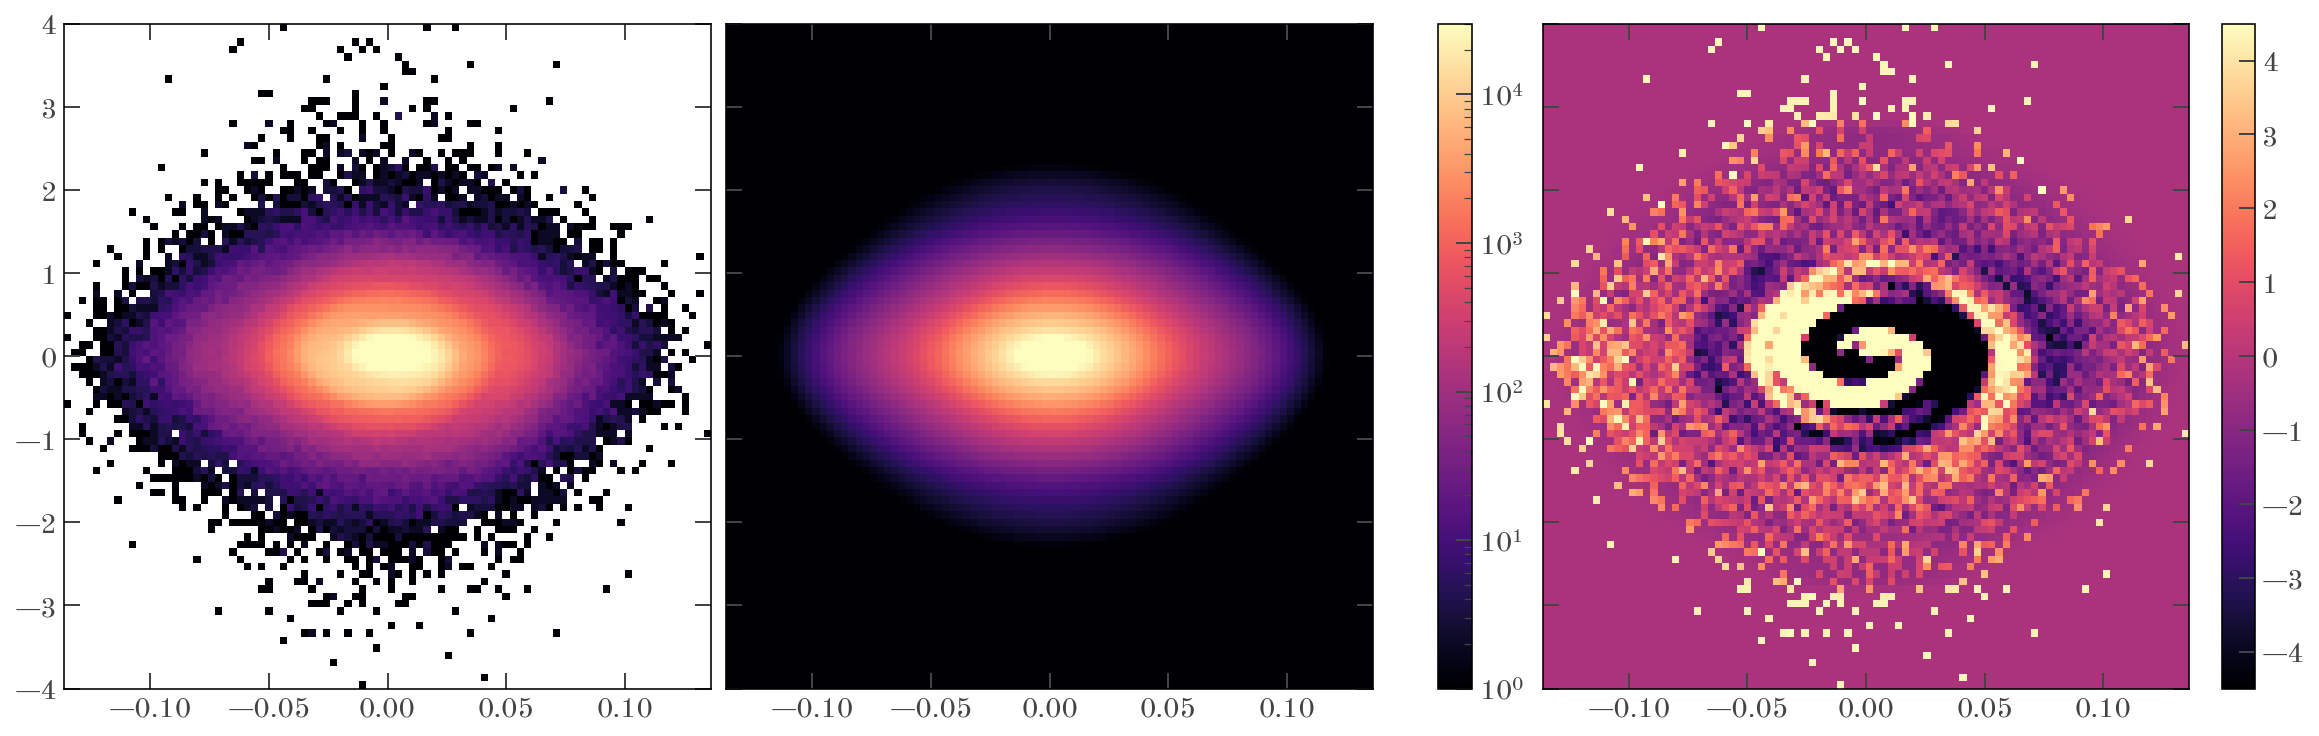

In [411]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True, 
                         constrained_layout=True)

cs = axes[0].pcolormesh(im_bins['vz'], im_bins['z'], data_H.T, **vlim)

model_H = np.exp(ln_density(res.params, yc, xc))
cs = axes[1].pcolormesh(xc, yc, model_H,
                        **vlim)
fig.colorbar(cs, ax=axes[0:2])

cs = axes[2].pcolormesh(
    xc, yc, (data_H.T - model_H) / np.sqrt(model_H), 
    vmin=-4.5, vmax=4.5
)
fig.colorbar(cs, ax=axes[2])

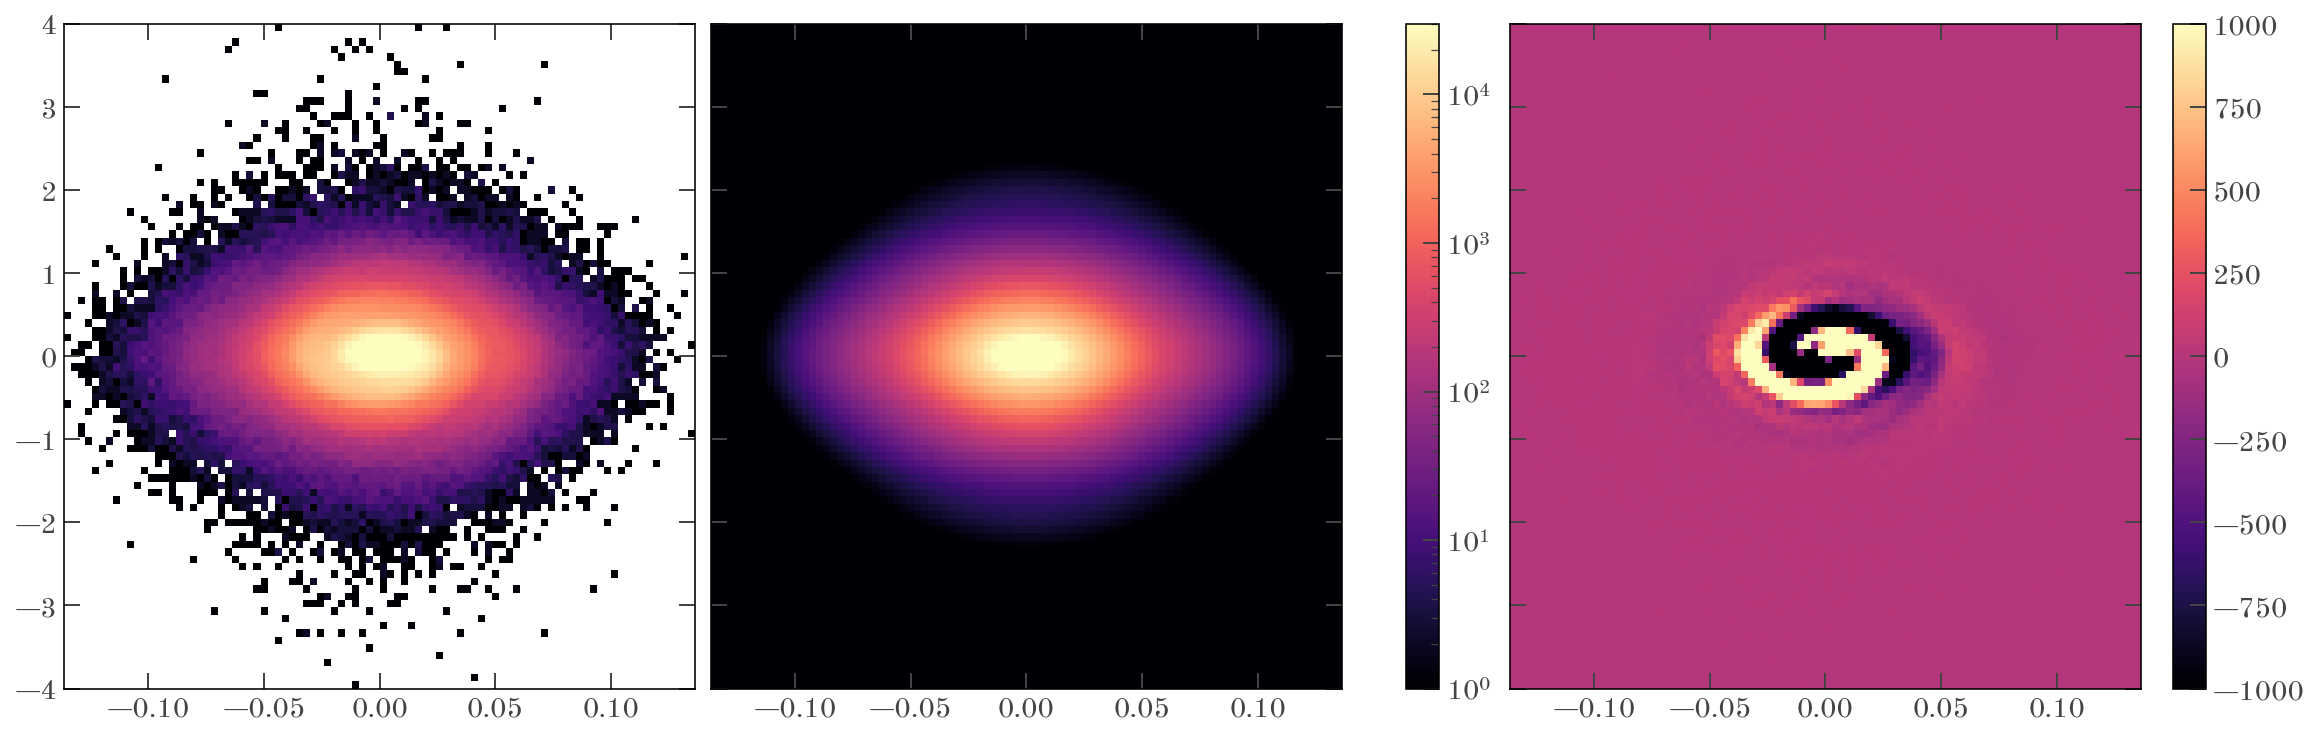

In [412]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True, 
                         constrained_layout=True)

cs = axes[0].pcolormesh(im_bins['vz'], im_bins['z'], data_H.T, **vlim)

model_H = np.exp(ln_density(res.params, yc, xc))
cs = axes[1].pcolormesh(xc, yc, model_H,
                        **vlim)
fig.colorbar(cs, ax=axes[0:2])

cs = axes[2].pcolormesh(
    xc, yc, (data_H.T - model_H), 
    vmin=-1000, vmax=1000
)
fig.colorbar(cs, ax=axes[2])

In [413]:
res.params

{'e2_vals': DeviceArray([ 1.00000000e+00,  5.60619241e-01,  3.05431988e-01,
               4.43062570e-01,  2.22211214e-01, -4.26681061e-01,
              -6.06314305e-01,  9.25238344e-02, -3.41536829e-04],            dtype=float64),
 'ln_Omega': DeviceArray(-2.53085646, dtype=float64),
 'ln_amps': DeviceArray([ 8.45672004,  8.32211171,  6.34754096, -2.29207441,
              -0.27520368], dtype=float64),
 'ln_e4_vals': DeviceArray([-6.01338768, -2.02367133, -2.87085631, -4.78556754,
              -1.3159475 , -2.14580406, -1.99707568, -2.00190273,
              -1.99976175], dtype=float64),
 'ln_scales': DeviceArray([-3.49378547, -2.70925456, -2.13198794,  1.85923182,
               1.9498724 ], dtype=float64),
 'vz0': DeviceArray(0.00119781, dtype=float64),
 'z0': DeviceArray(0.01253432, dtype=float64)}

---

# Matched filter

In [66]:
N = len(test_data)

rng = np.random.default_rng(seed=42)
idx = rng.choice(N, size=N, replace=False)

A_idx = idx[:N//2]
B_idx = idx[N//2:]
xc, yc, data_H_A = get_data_im(test_data['z'][A_idx], test_data['vz'][A_idx])
xc, yc, data_H_B = get_data_im(test_data['z'][B_idx], test_data['vz'][B_idx])

In [67]:
reses = []
for data_H in [data_H_A, data_H_B]:
    optimizer = jaxopt.ScipyMinimize(
        fun=objective, 
        method='L-BFGS-B', 
        maxiter=16384,
    )
    res = optimizer.run(init_params=params0, z=yc, vz=xc, H=data_H.T)
    reses.append(res)

In [68]:
[r.state for r in reses]

[ScipyMinimizeInfo(fun_val=DeviceArray(1.0932725, dtype=float64, weak_type=True), success=True, status=0, iter_num=3629),
 ScipyMinimizeInfo(fun_val=DeviceArray(1.08198305, dtype=float64, weak_type=True), success=True, status=0, iter_num=2711)]

TODO: write poisson likelihood of fitting my model (fixed parameters) + amplitude of residual from patch A to patch B. What's the equation for the maximum likelihood amplitude value?

In [70]:
model_H_A = np.exp(ln_density(reses[0].params, yc, xc))
model_H_B = np.exp(ln_density(reses[1].params, yc, xc))

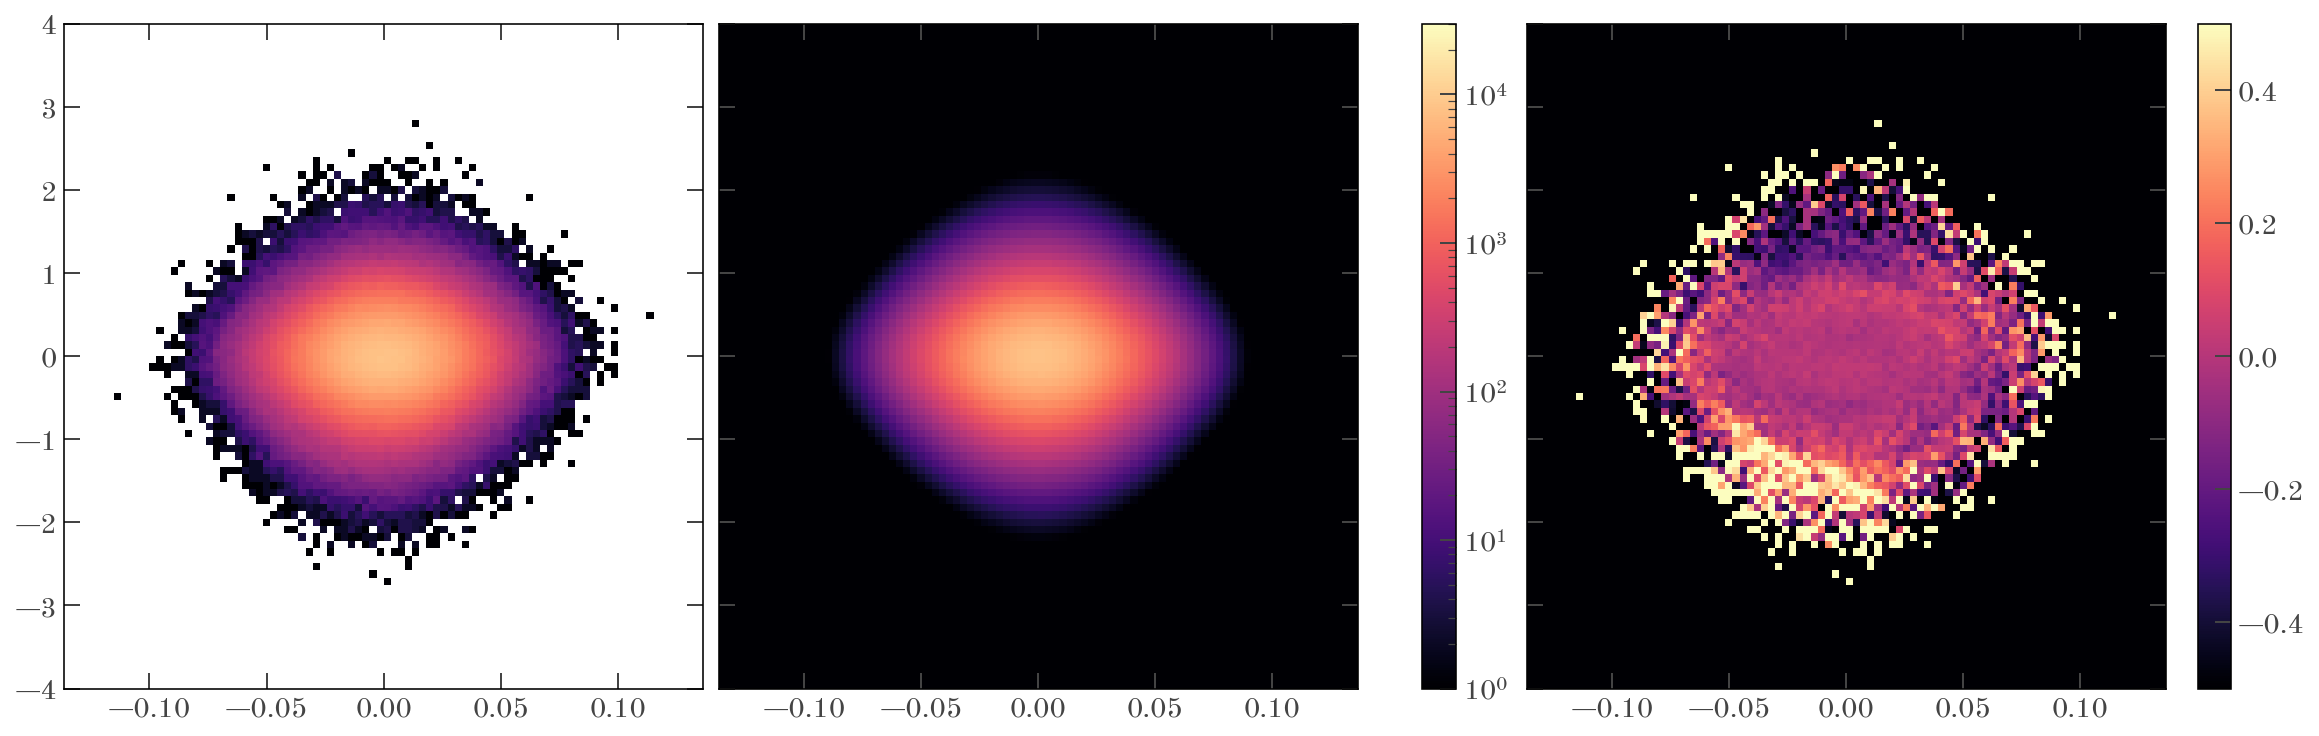

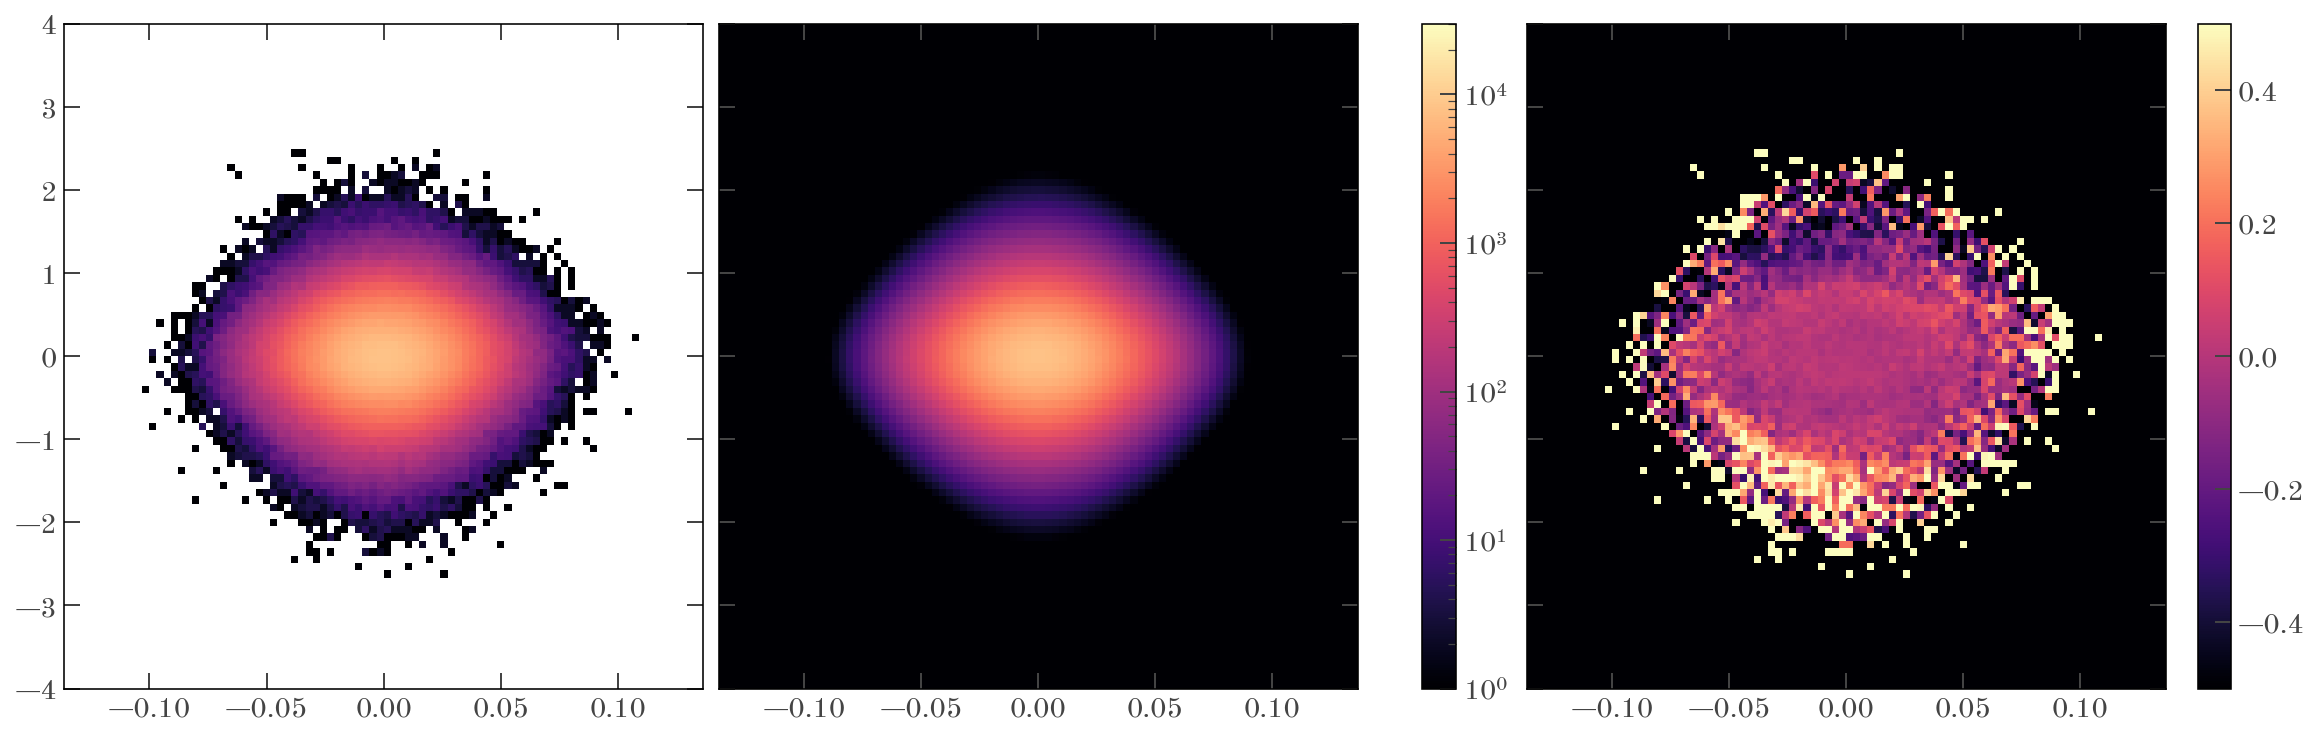

In [75]:
for res, data_H, model_H in zip(reses, [data_H_A, data_H_B], [model_H_A, model_H_B]):
    fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True, 
                             constrained_layout=True)

    cs = axes[0].pcolormesh(im_bins['vz'], im_bins['z'], data_H.T, **vlim)
    cs = axes[1].pcolormesh(xc, yc, model_H, **vlim)
    fig.colorbar(cs, ax=axes[0:2])

    cs = axes[2].pcolormesh(
        xc, yc, (data_H.T - model_H) / model_H, 
        vmin=-.5, vmax=.5
    )
    fig.colorbar(cs, ax=axes[2])

In [71]:
np.sum((data_H_A - model_H_A) / model_H_A * data_H_B)

104364344.2826423

In [72]:
np.sum((data_H_B - model_H_B) / model_H_B * data_H_A)

1034428.1524216

---

# Action-angle

In [29]:
rz, rz_prime, th_prime = get_rz_th(
    z=test_data['z'].to_value(u.kpc),
    vz=test_data['vz'].to_value(u.kpc/u.Myr),
    Omega=np.exp(res.params['ln_Omega']),
    e2_vals=res.params['e2_vals'],
    ln_e4_vals=res.params['ln_e4_vals'],
)

In [97]:
@jax.jit
def distort_both(e2, e4, rz, th):
    rz_factor = 1 + e2 * rz * jnp.cos(2 * th) - e4 * rz * jnp.cos(4 * th)
    th_factor = 1 - e2 * rz * jnp.sin(2 * th) + e4 * rz * jnp.sin(4 * th)
    return rz_factor, th_factor


@jax.jit
def get_distorted_rz_th(init_rz, init_th, e2_vals, ln_e4_vals):
    e2_interp = InterpolatedUnivariateSpline(
        e4_knots,
        e2_vals,
        k=3
    )
    ln_e4_interp = InterpolatedUnivariateSpline(
        e4_knots,
        ln_e4_vals,
        k=3
    )
    
    rz_fac, th_fac = distort_both(
        e2=e2_interp(init_rz), 
        e4=jnp.exp(ln_e4_interp(init_rz)), 
        rz=init_rz, 
        th=init_th
    )
    
    rz = init_rz * rz_fac
    th = init_th * th_fac
    
    return rz, th

In [98]:
new_rz, new_th = get_distorted_rz_th(
    rz_prime, 
    th_prime, 
    e2_vals=res.params['e2_vals'],
    ln_e4_vals=res.params['ln_e4_vals'] - 10
)

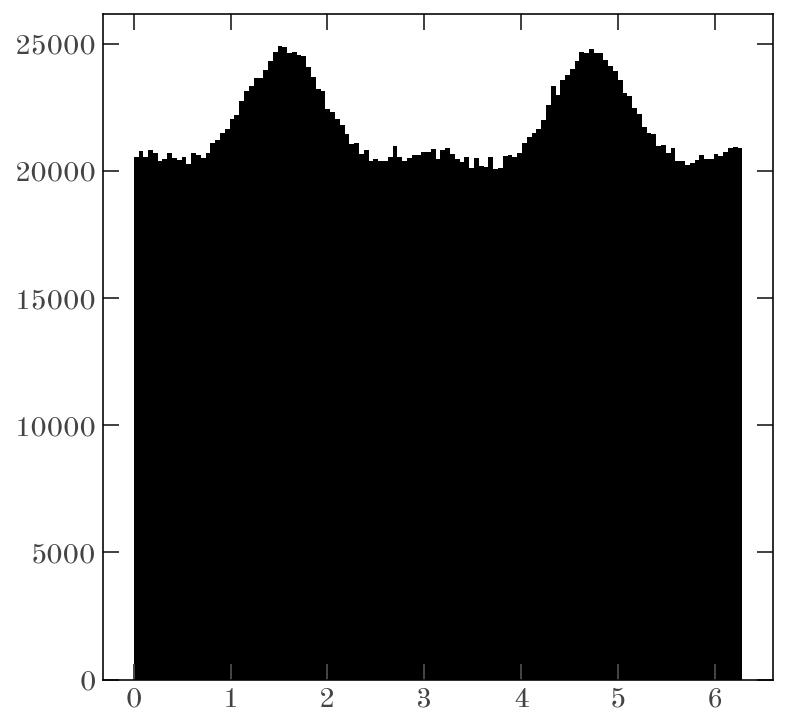

In [100]:
plt.hist(np.asarray(th_prime) % (2*np.pi), bins=np.linspace(0, 2*np.pi, 128));
# plt.hist(np.asarray(new_th) % (2*np.pi), bins=np.linspace(0, 2*np.pi, 128));

(0.0, 0.75)

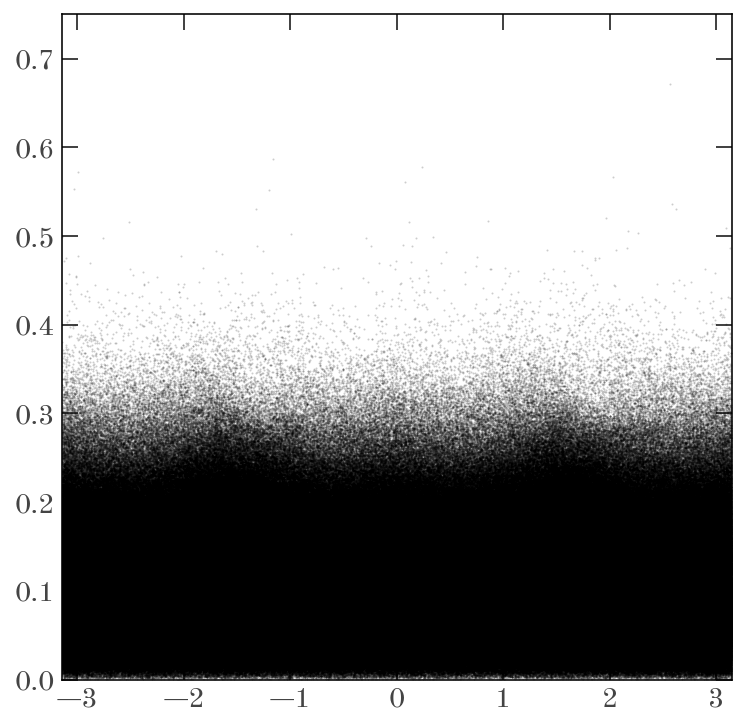

In [36]:
plt.plot(th_prime, rz, ls='none', marker='o', ms=1., alpha=0.2)
plt.xlim(-np.pi, np.pi)
plt.ylim(0, 0.75)

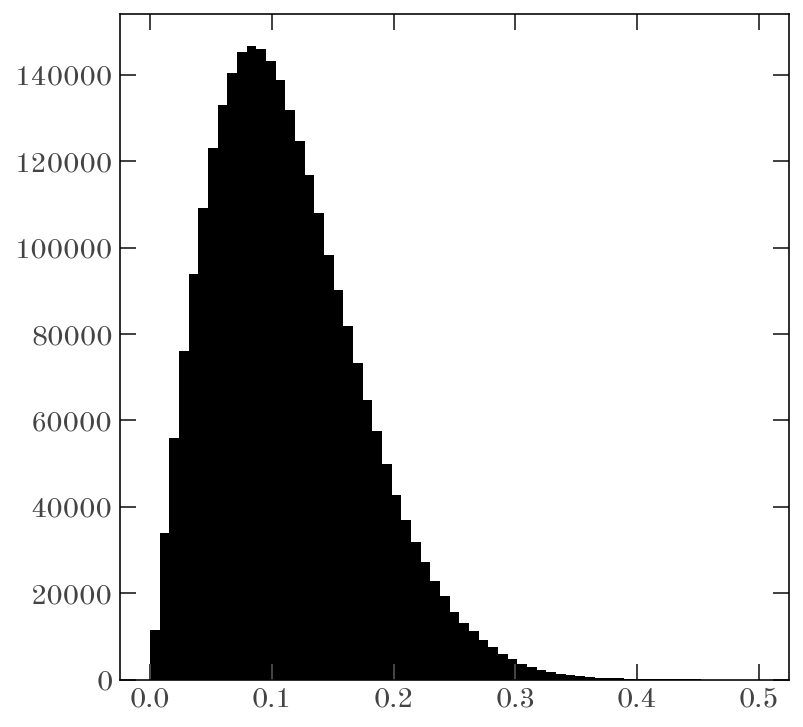

In [37]:
plt.hist(np.array(rz), bins=np.linspace(0, 0.5, 64));

TODO: Like Kepler's equation! But with the m=4 distortion. Assume it's same coefficient, solve on a grid of r_z?

In [ ]:
x = x_p * (1 + A*cos(th_p))
th = th_p * (1 - A*sin(th_p))